In [98]:
# Import library
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.models import load_model
import matplotlib.ticker as ticker
from sklearn import metrics
import math
import scipy.stats as stats
import itertools

In [99]:
# Load CMPP stock dataset
df_cmpp = pd.read_excel(
    'transportation_stocks.xlsx', sheet_name='CMPP.JK')
df_cmpp.set_index('Date', drop=True, inplace=True)
df_cmpp.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-04-01,59508224.0,59508224.0,59508224.0,59508224.0,59508224.0,20165.0
2011-04-04,59508224.0,59508224.0,59508224.0,59508224.0,59508224.0,20165.0
2011-04-05,59508224.0,59508224.0,59508224.0,59508224.0,59508224.0,20165.0
2011-04-06,59508224.0,59508224.0,59508224.0,59508224.0,59508224.0,20165.0
2011-04-07,55788960.0,65707001.0,52069695.0,55788960.0,55788960.0,1205883.0


In [100]:
# Check datatypes
print(df_cmpp.dtypes)

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object


In [101]:
# Check missing value
print(df_cmpp.isnull().sum())

Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64


In [102]:
# Fill missing value using mean imputation
for i in df_cmpp[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]:
    df_cmpp[i].fillna(df_cmpp[i].mean(), inplace=True)

print(df_cmpp.isnull().sum())

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


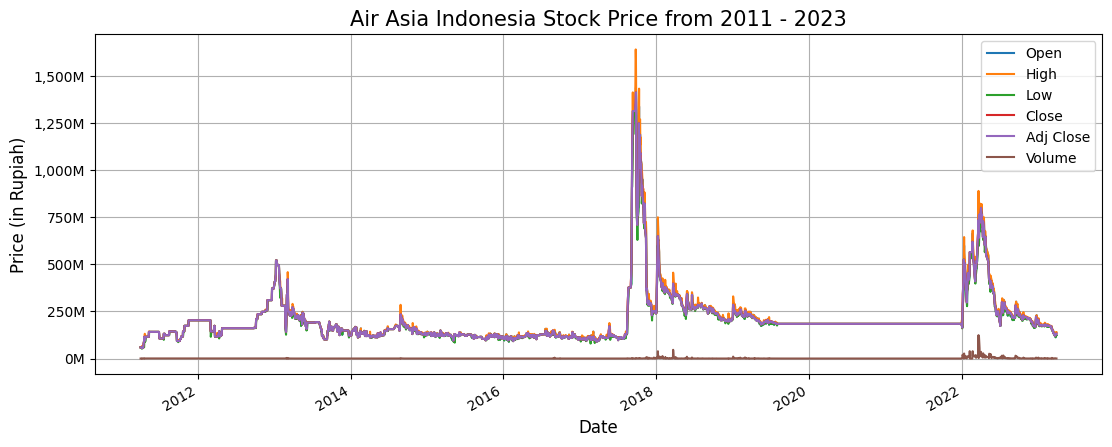

In [103]:
# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# Visualize the historical prices from 2022 - 2023
df_cmpp.plot(figsize=(13,5))
plt.title('Air Asia Indonesia Stock Price from 2011 - 2023', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

In [104]:
# Select the close price column as the target variable
target_col = 'Close'

# Create a new dataframe with only the target variable
target_df = pd.DataFrame(df_cmpp[target_col])

# Split the data into training and testing sets
train_size = int(len(target_df) * 0.9)
train_df = target_df[:train_size]
test_df = target_df[train_size:]
print('Training Set: ', train_df.shape)
print('Testing Set: ', test_df.shape)

Training Set:  (2682, 1)
Testing Set:  (298, 1)


In [105]:
# Scale the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_df)
test_scaled = scaler.transform(test_df)
print('Training Scaled: ', train_scaled[0:5], '\n')
print('Testing Scaled: ', test_scaled[0:5])

Training Scaled:  [[0.00273973]
 [0.00273973]
 [0.00273973]
 [0.00273973]
 [0.        ]] 

Testing Scaled:  [[0.30954058]
 [0.28596838]
 [0.26976249]
 [0.24913682]
 [0.2299844 ]]


In [106]:
# Define the sequence length and number of features
sequence_length = 60
num_features = 1

# Define the function to create sequences
def create_sequences(X, y, seq_length):
    X_sequences, y_sequences = [], []
    for i in range(seq_length, len(X)):
        X_sequences.append(X[i-seq_length:i, :])
        y_sequences.append(y[i, :])
    return np.array(X_sequences), np.array(y_sequences)

# Create training sequences and labels
X_train, y_train = create_sequences(train_scaled, train_scaled, sequence_length)

# Create testing sequences and labels
X_test, y_test = create_sequences(test_scaled, test_scaled, sequence_length)

# Print the shape of the training and testing sets
print('X train shape:', X_train.shape)
print('y train shape:', y_train.shape)
print('X test shape:', X_test.shape)
print('y test shape:', y_test.shape)

X train shape: (2622, 60, 1)
y train shape: (2622, 1)
X test shape: (238, 60, 1)
y test shape: (238, 1)


## LSTM Default Model

In [107]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(32, input_shape=(sequence_length, num_features)))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/cmpp_lstm_default.h5')

Epoch 1/10
24/24 [==============================] - 4s 62ms/step - loss: 0.0077 - val_loss: 9.1345e-04
Epoch 2/10
24/24 [==============================] - 1s 34ms/step - loss: 0.0024 - val_loss: 9.7846e-04
Epoch 3/10
24/24 [==============================] - 1s 35ms/step - loss: 0.0018 - val_loss: 7.5923e-04
Epoch 4/10
24/24 [==============================] - 1s 38ms/step - loss: 0.0015 - val_loss: 6.0621e-04
Epoch 5/10
24/24 [==============================] - 1s 35ms/step - loss: 0.0013 - val_loss: 5.7490e-04
Epoch 6/10
24/24 [==============================] - 1s 36ms/step - loss: 0.0012 - val_loss: 5.8058e-04
Epoch 7/10
24/24 [==============================] - 1s 34ms/step - loss: 0.0011 - val_loss: 5.1404e-04
Epoch 8/10
24/24 [==============================] - 1s 33ms/step - loss: 9.8643e-04 - val_loss: 4.9021e-04
Epoch 9/10
24/24 [==============================] - 1s 34ms/step - loss: 9.3039e-04 - val_loss: 6.5136e-04
Epoch 10/10
24/24 [==============================] - 1s 35ms/step

In [108]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 1s 7ms/step
Mean Absolute Error (MAE): 0.0146438
Mean Absolute Percentage Error (MAPE): 0.10927
Root Mean Squared Error (RMSE): 0.01888
Mean Squared Error (MSE): 0.0003563
R-Squared (R2): 0.939591
T-Statistic 0.6738
P-Value 3.628826403089144e-21
Elapsed Time (min): 12.14


7/7 [==============================] - 0s 7ms/step


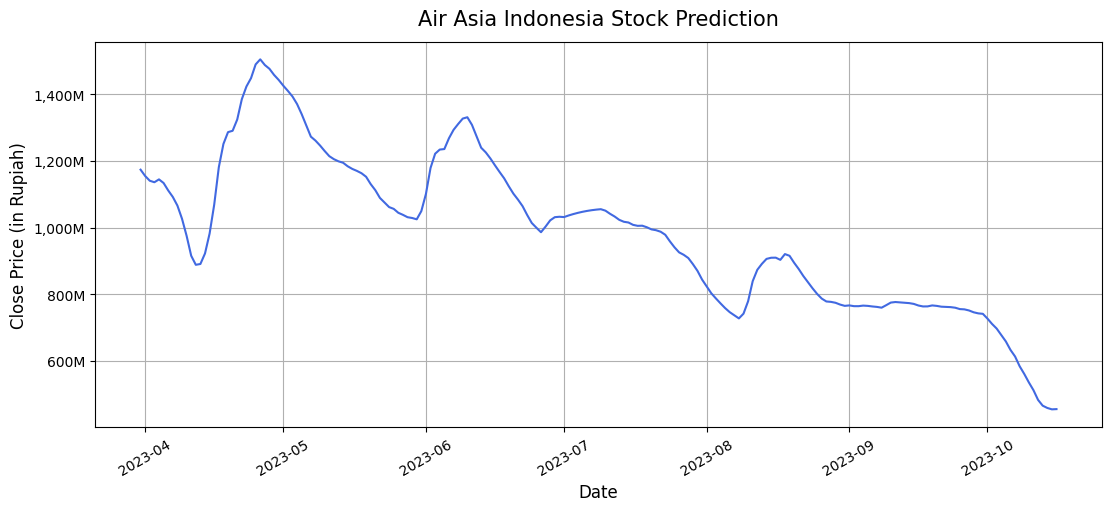

In [109]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - Adam

In [110]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/cmpp_linear_adam.h5')

Epoch 1/10
24/24 [==============================] - 17s 442ms/step - loss: 0.0033 - val_loss: 8.0529e-04
Epoch 2/10
24/24 [==============================] - 10s 405ms/step - loss: 0.0016 - val_loss: 6.2608e-04
Epoch 3/10
24/24 [==============================] - 10s 436ms/step - loss: 0.0013 - val_loss: 5.0392e-04
Epoch 4/10
24/24 [==============================] - 11s 456ms/step - loss: 0.0012 - val_loss: 4.8119e-04
Epoch 5/10
24/24 [==============================] - 11s 456ms/step - loss: 0.0012 - val_loss: 4.0451e-04
Epoch 6/10
24/24 [==============================] - 11s 474ms/step - loss: 8.4751e-04 - val_loss: 3.7806e-04
Epoch 7/10
24/24 [==============================] - 11s 480ms/step - loss: 8.4201e-04 - val_loss: 3.2678e-04
Epoch 8/10
24/24 [==============================] - 11s 467ms/step - loss: 8.8938e-04 - val_loss: 3.0641e-04
Epoch 9/10
24/24 [==============================] - 11s 476ms/step - loss: 7.9478e-04 - val_loss: 3.8092e-04
Epoch 10/10
24/24 [====================

In [111]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 45ms/step
Mean Absolute Error (MAE): 0.0121662
Mean Absolute Percentage Error (MAPE): 0.09417
Root Mean Squared Error (RMSE): 0.01635
Mean Squared Error (MSE): 0.0002672
R-Squared (R2): 0.954698
T-Statistic 0.7057
P-Value 3.40213699076349e-20
Elapsed Time (min): 116.18


7/7 [==============================] - 0s 44ms/step


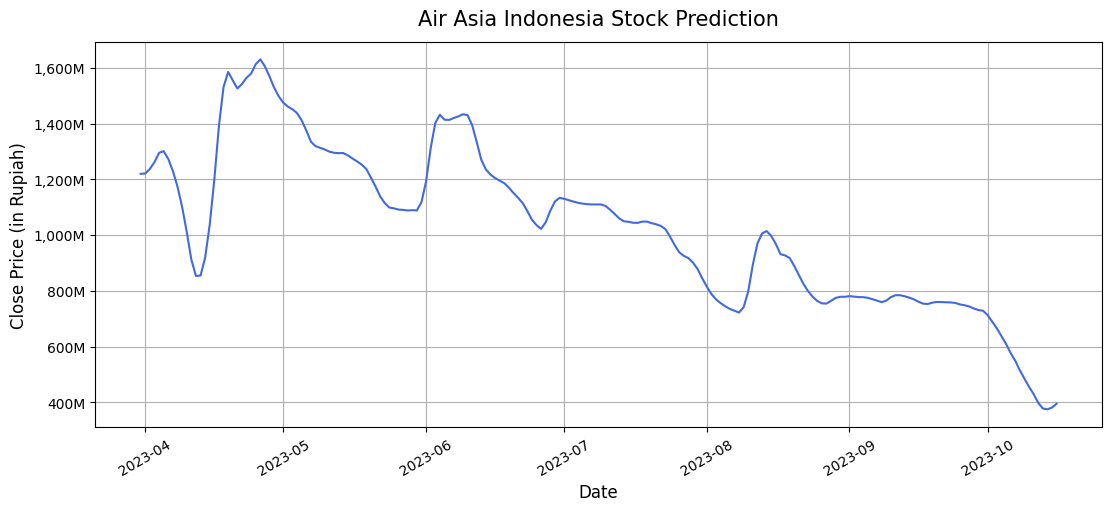

In [112]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - AdaGrad

In [113]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/cmpp_linear_adagrad.h5')

Epoch 1/10
24/24 [==============================] - 17s 475ms/step - loss: 0.0177 - val_loss: 0.0024
Epoch 2/10
24/24 [==============================] - 11s 441ms/step - loss: 0.0130 - val_loss: 0.0012
Epoch 3/10
24/24 [==============================] - 11s 439ms/step - loss: 0.0123 - val_loss: 0.0011
Epoch 4/10
24/24 [==============================] - 10s 431ms/step - loss: 0.0120 - val_loss: 0.0011
Epoch 5/10
24/24 [==============================] - 10s 434ms/step - loss: 0.0119 - val_loss: 0.0011
Epoch 6/10
24/24 [==============================] - 11s 445ms/step - loss: 0.0115 - val_loss: 0.0011
Epoch 7/10
24/24 [==============================] - 12s 494ms/step - loss: 0.0114 - val_loss: 0.0011
Epoch 8/10
24/24 [==============================] - 12s 498ms/step - loss: 0.0112 - val_loss: 0.0011
Epoch 9/10
24/24 [==============================] - 12s 489ms/step - loss: 0.0111 - val_loss: 0.0011
Epoch 10/10
24/24 [==============================] - 12s 489ms/step - loss: 0.0111 - val_lo

In [114]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 42ms/step
Mean Absolute Error (MAE): 0.0457831
Mean Absolute Percentage Error (MAPE): 0.2762
Root Mean Squared Error (RMSE): 0.08112
Mean Squared Error (MSE): 0.0065805
R-Squared (R2): -0.115791
T-Statistic 0.7162
P-Value 7.378491130533927e-20
Elapsed Time (min): 117.75


7/7 [==============================] - 0s 52ms/step


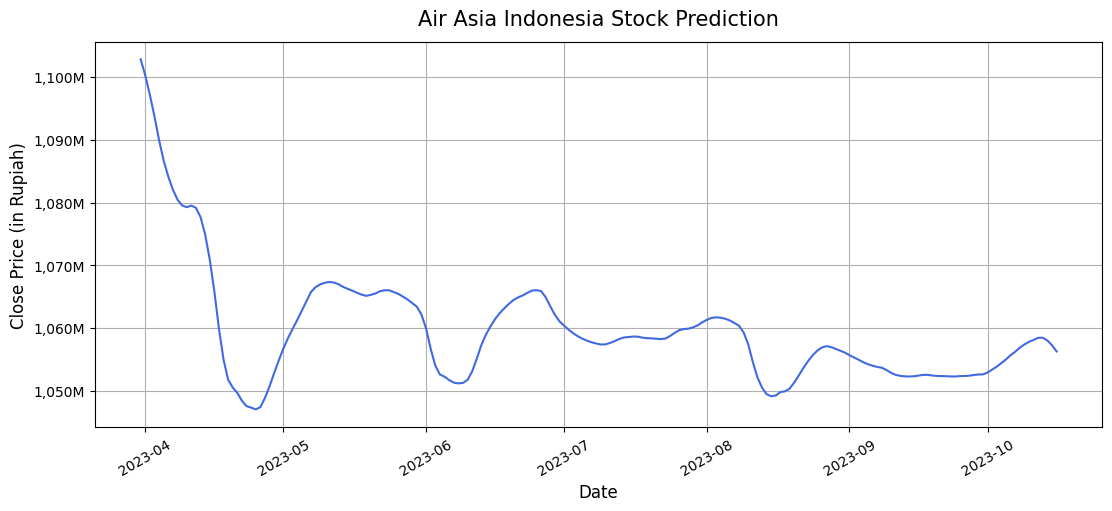

In [115]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - Nadam

In [116]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/cmpp_linear_nadam.h5')

Epoch 1/10
24/24 [==============================] - 22s 595ms/step - loss: 0.0048 - val_loss: 8.4772e-04
Epoch 2/10
24/24 [==============================] - 12s 504ms/step - loss: 0.0018 - val_loss: 6.5679e-04
Epoch 3/10
24/24 [==============================] - 13s 549ms/step - loss: 0.0015 - val_loss: 5.7930e-04
Epoch 4/10
24/24 [==============================] - 12s 517ms/step - loss: 0.0014 - val_loss: 5.8154e-04
Epoch 5/10
24/24 [==============================] - 12s 487ms/step - loss: 0.0012 - val_loss: 4.6814e-04
Epoch 6/10
24/24 [==============================] - 13s 525ms/step - loss: 9.7555e-04 - val_loss: 4.5080e-04
Epoch 7/10
24/24 [==============================] - 13s 523ms/step - loss: 9.9062e-04 - val_loss: 3.7568e-04
Epoch 8/10
24/24 [==============================] - 14s 570ms/step - loss: 0.0010 - val_loss: 3.5080e-04
Epoch 9/10
24/24 [==============================] - 12s 517ms/step - loss: 8.4523e-04 - val_loss: 3.2335e-04
Epoch 10/10
24/24 [========================

In [117]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 48ms/step
Mean Absolute Error (MAE): 0.0119413
Mean Absolute Percentage Error (MAPE): 0.08811
Root Mean Squared Error (RMSE): 0.01637
Mean Squared Error (MSE): 0.000268
R-Squared (R2): 0.954561
T-Statistic 0.7059
P-Value 3.4518263117709184e-20
Elapsed Time (min): 135.91


7/7 [==============================] - 0s 50ms/step


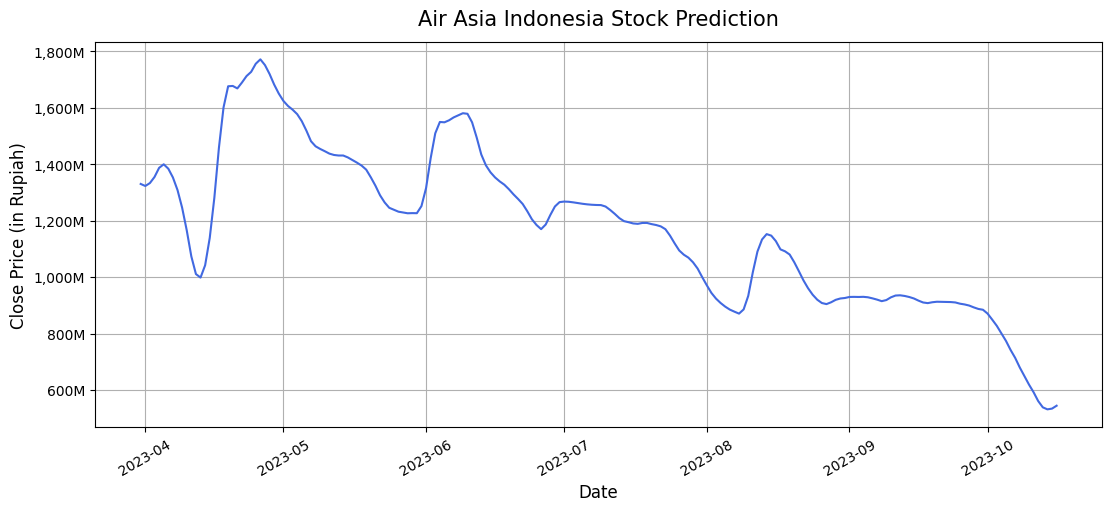

In [118]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - RMSProp

In [119]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/cmpp_linear_rmsprop.h5')

Epoch 1/10
24/24 [==============================] - 22s 628ms/step - loss: 0.0039 - val_loss: 0.0062
Epoch 2/10
24/24 [==============================] - 13s 540ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 3/10
24/24 [==============================] - 13s 548ms/step - loss: 0.0021 - val_loss: 6.5520e-04
Epoch 4/10
24/24 [==============================] - 14s 596ms/step - loss: 0.0018 - val_loss: 5.9572e-04
Epoch 5/10
24/24 [==============================] - 15s 615ms/step - loss: 0.0020 - val_loss: 0.0010
Epoch 6/10
24/24 [==============================] - 13s 530ms/step - loss: 0.0016 - val_loss: 5.9901e-04
Epoch 7/10
24/24 [==============================] - 13s 541ms/step - loss: 0.0014 - val_loss: 7.1471e-04
Epoch 8/10
24/24 [==============================] - 14s 575ms/step - loss: 0.0015 - val_loss: 5.2505e-04
Epoch 9/10
24/24 [==============================] - 13s 561ms/step - loss: 0.0014 - val_loss: 4.9751e-04
Epoch 10/10
24/24 [==============================] - 14s 578ms/step

In [120]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 56ms/step
Mean Absolute Error (MAE): 0.0181908
Mean Absolute Percentage Error (MAPE): 0.14688
Root Mean Squared Error (RMSE): 0.022
Mean Squared Error (MSE): 0.0004841
R-Squared (R2): 0.91791
T-Statistic 0.6806
P-Value 5.77478090467675e-21
Elapsed Time (min): 146.07


7/7 [==============================] - 0s 48ms/step


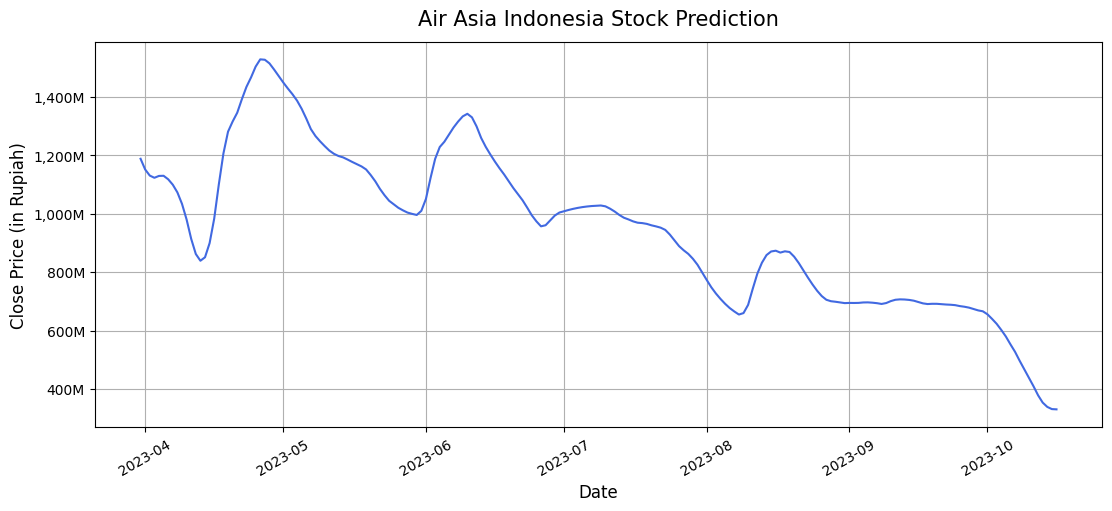

In [121]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - AdaDelta

In [122]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/cmpp_linear_adadelta.h5')

Epoch 1/10
24/24 [==============================] - 23s 643ms/step - loss: 0.0202 - val_loss: 0.0099
Epoch 2/10
24/24 [==============================] - 13s 548ms/step - loss: 0.0197 - val_loss: 0.0097
Epoch 3/10
24/24 [==============================] - 13s 520ms/step - loss: 0.0195 - val_loss: 0.0095
Epoch 4/10
24/24 [==============================] - 14s 572ms/step - loss: 0.0193 - val_loss: 0.0093
Epoch 5/10
24/24 [==============================] - 14s 592ms/step - loss: 0.0191 - val_loss: 0.0091
Epoch 6/10
24/24 [==============================] - 13s 552ms/step - loss: 0.0187 - val_loss: 0.0089
Epoch 7/10
24/24 [==============================] - 13s 532ms/step - loss: 0.0185 - val_loss: 0.0087
Epoch 8/10
24/24 [==============================] - 12s 515ms/step - loss: 0.0183 - val_loss: 0.0085
Epoch 9/10
24/24 [==============================] - 13s 540ms/step - loss: 0.0179 - val_loss: 0.0083
Epoch 10/10
24/24 [==============================] - 12s 517ms/step - loss: 0.0180 - val_lo

In [123]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 55ms/step
Mean Absolute Error (MAE): 0.1189503
Mean Absolute Percentage Error (MAPE): 0.84968
Root Mean Squared Error (RMSE): 0.13877
Mean Squared Error (MSE): 0.0192562
R-Squared (R2): -2.265067
T-Statistic 0.6873
P-Value 9.157175339884715e-21
Elapsed Time (min): 141.16


7/7 [==============================] - 0s 53ms/step


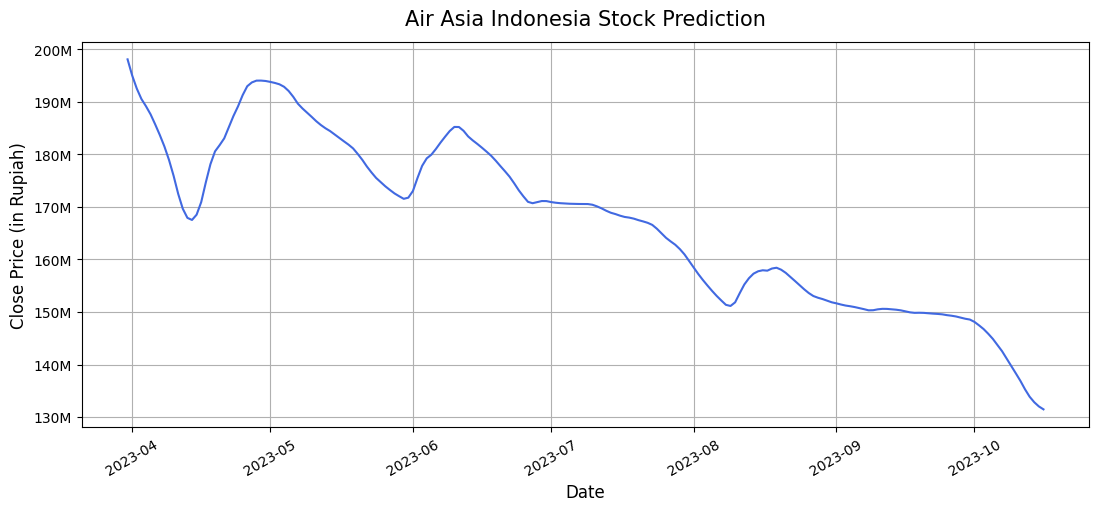

In [124]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - SGD

In [125]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/cmpp_linear_sgd.h5')

Epoch 1/10
24/24 [==============================] - 21s 597ms/step - loss: 0.0133 - val_loss: 0.0011
Epoch 2/10
24/24 [==============================] - 13s 551ms/step - loss: 0.0113 - val_loss: 0.0011
Epoch 3/10
24/24 [==============================] - 13s 558ms/step - loss: 0.0105 - val_loss: 0.0011
Epoch 4/10
24/24 [==============================] - 14s 586ms/step - loss: 0.0103 - val_loss: 0.0011
Epoch 5/10
24/24 [==============================] - 15s 616ms/step - loss: 0.0098 - val_loss: 0.0011
Epoch 6/10
24/24 [==============================] - 15s 610ms/step - loss: 0.0094 - val_loss: 0.0011
Epoch 7/10
24/24 [==============================] - 14s 595ms/step - loss: 0.0089 - val_loss: 0.0010
Epoch 8/10
24/24 [==============================] - 13s 545ms/step - loss: 0.0087 - val_loss: 0.0010
Epoch 9/10
24/24 [==============================] - 14s 573ms/step - loss: 0.0082 - val_loss: 0.0010
Epoch 10/10
24/24 [==============================] - 14s 564ms/step - loss: 0.0080 - val_lo

In [126]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 58ms/step
Mean Absolute Error (MAE): 0.0364132
Mean Absolute Percentage Error (MAPE): 0.22087
Root Mean Squared Error (RMSE): 0.06329
Mean Squared Error (MSE): 0.004005
R-Squared (R2): 0.320908
T-Statistic 0.6638
P-Value 1.8622087313136516e-21
Elapsed Time (min): 147.05


7/7 [==============================] - 0s 58ms/step


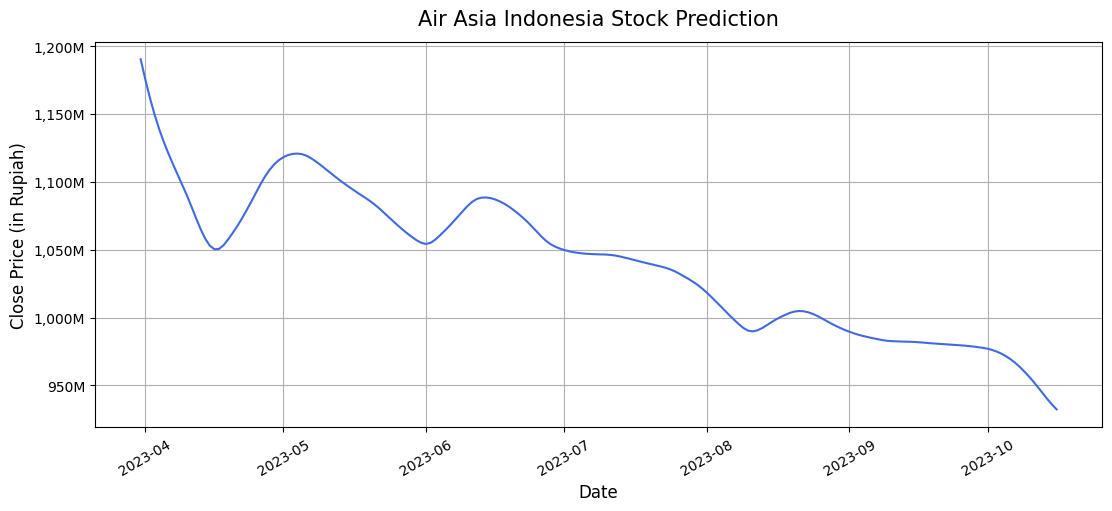

In [127]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - AdaMax

In [128]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/cmpp_linear_adamax.h5')

Epoch 1/10
24/24 [==============================] - 19s 501ms/step - loss: 0.0050 - val_loss: 8.2750e-04
Epoch 2/10
24/24 [==============================] - 11s 445ms/step - loss: 0.0021 - val_loss: 7.5014e-04
Epoch 3/10
24/24 [==============================] - 10s 427ms/step - loss: 0.0018 - val_loss: 7.2007e-04
Epoch 4/10
24/24 [==============================] - 11s 447ms/step - loss: 0.0016 - val_loss: 7.0019e-04
Epoch 5/10
24/24 [==============================] - 10s 434ms/step - loss: 0.0016 - val_loss: 6.8328e-04
Epoch 6/10
24/24 [==============================] - 11s 473ms/step - loss: 0.0015 - val_loss: 8.6827e-04
Epoch 7/10
24/24 [==============================] - 11s 444ms/step - loss: 0.0014 - val_loss: 5.9751e-04
Epoch 8/10
24/24 [==============================] - 11s 444ms/step - loss: 0.0014 - val_loss: 5.9286e-04
Epoch 9/10
24/24 [==============================] - 11s 471ms/step - loss: 0.0012 - val_loss: 5.6830e-04
Epoch 10/10
24/24 [==============================] - 12

In [129]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 57ms/step
Mean Absolute Error (MAE): 0.0168838
Mean Absolute Percentage Error (MAPE): 0.13477
Root Mean Squared Error (RMSE): 0.02189
Mean Squared Error (MSE): 0.0004791
R-Squared (R2): 0.918757
T-Statistic 0.6834
P-Value 7.014716968854853e-21
Elapsed Time (min): 118.2


7/7 [==============================] - 0s 57ms/step


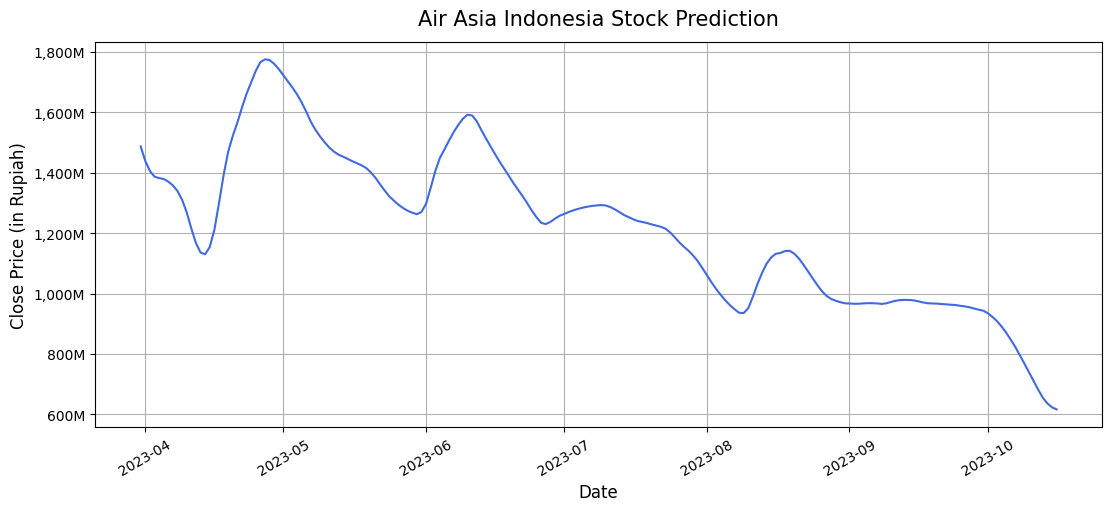

In [130]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - Adam

In [131]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/cmpp_relu_adam.h5')

Epoch 1/10
24/24 [==============================] - 18s 446ms/step - loss: 0.0064 - val_loss: 0.0010
Epoch 2/10
24/24 [==============================] - 9s 370ms/step - loss: 0.0020 - val_loss: 7.6080e-04
Epoch 3/10
24/24 [==============================] - 9s 379ms/step - loss: 0.0018 - val_loss: 6.4158e-04
Epoch 4/10
24/24 [==============================] - 10s 415ms/step - loss: 0.0015 - val_loss: 5.6341e-04
Epoch 5/10
24/24 [==============================] - 9s 371ms/step - loss: 0.0013 - val_loss: 7.0635e-04
Epoch 6/10
24/24 [==============================] - 10s 405ms/step - loss: 0.0012 - val_loss: 4.7229e-04
Epoch 7/10
24/24 [==============================] - 10s 410ms/step - loss: 0.0011 - val_loss: 4.3763e-04
Epoch 8/10
24/24 [==============================] - 10s 419ms/step - loss: 9.4845e-04 - val_loss: 4.1114e-04
Epoch 9/10
24/24 [==============================] - 9s 389ms/step - loss: 8.6807e-04 - val_loss: 4.7791e-04
Epoch 10/10
24/24 [==============================] - 10

In [132]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 57ms/step
Mean Absolute Error (MAE): 0.0092918
Mean Absolute Percentage Error (MAPE): 0.06422
Root Mean Squared Error (RMSE): 0.01457
Mean Squared Error (MSE): 0.0002123
R-Squared (R2): 0.963999
T-Statistic 0.7102
P-Value 4.716007411287991e-20
Elapsed Time (min): 104.35


7/7 [==============================] - 0s 47ms/step


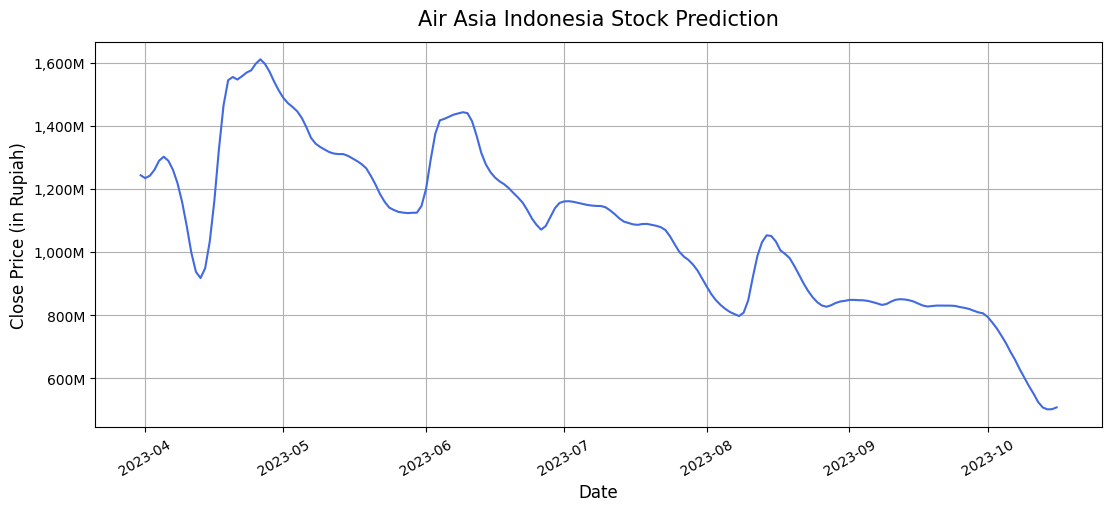

In [133]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - AdaGrad

In [134]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/cmpp_relu_adagrad.h5')

Epoch 1/10
24/24 [==============================] - 20s 531ms/step - loss: 0.0203 - val_loss: 0.0074
Epoch 2/10
24/24 [==============================] - 11s 453ms/step - loss: 0.0173 - val_loss: 0.0054
Epoch 3/10
24/24 [==============================] - 11s 471ms/step - loss: 0.0154 - val_loss: 0.0040
Epoch 4/10
24/24 [==============================] - 11s 457ms/step - loss: 0.0139 - val_loss: 0.0030
Epoch 5/10
24/24 [==============================] - 11s 473ms/step - loss: 0.0131 - val_loss: 0.0023
Epoch 6/10
24/24 [==============================] - 11s 469ms/step - loss: 0.0123 - val_loss: 0.0018
Epoch 7/10
24/24 [==============================] - 11s 475ms/step - loss: 0.0120 - val_loss: 0.0015
Epoch 8/10
24/24 [==============================] - 11s 450ms/step - loss: 0.0116 - val_loss: 0.0014
Epoch 9/10
24/24 [==============================] - 11s 480ms/step - loss: 0.0114 - val_loss: 0.0013
Epoch 10/10
24/24 [==============================] - 12s 481ms/step - loss: 0.0113 - val_lo

In [135]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 43ms/step
Mean Absolute Error (MAE): 0.0530037
Mean Absolute Percentage Error (MAPE): 0.29859
Root Mean Squared Error (RMSE): 0.08869
Mean Squared Error (MSE): 0.0078665
R-Squared (R2): -0.333831
T-Statistic 0.6686
P-Value 2.5678794199394805e-21
Elapsed Time (min): 121.72


7/7 [==============================] - 0s 44ms/step


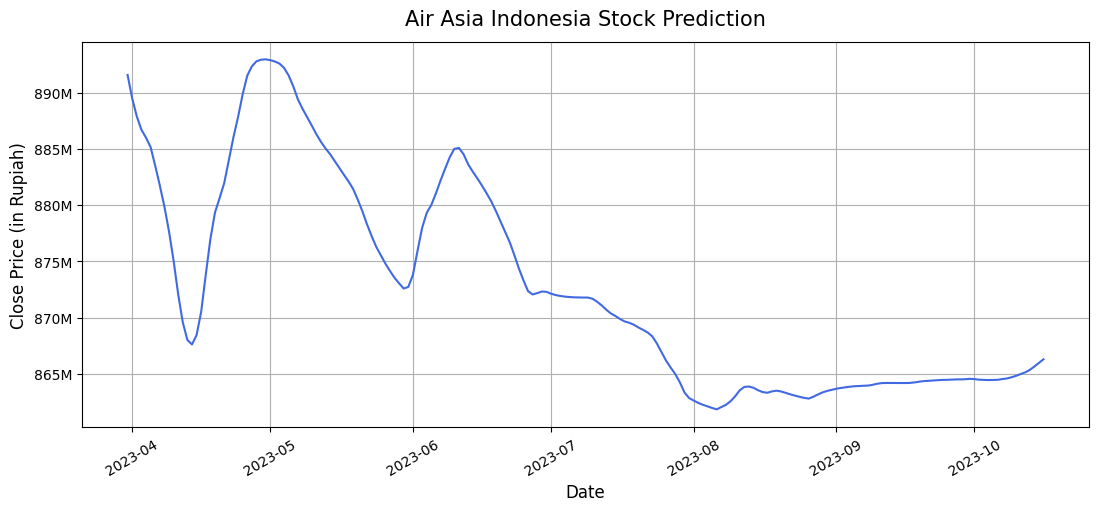

In [136]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - Nadam

In [137]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/cmpp_relu_nadam.h5')

Epoch 1/10
24/24 [==============================] - 20s 448ms/step - loss: 0.0063 - val_loss: 0.0013
Epoch 2/10
24/24 [==============================] - 10s 411ms/step - loss: 0.0020 - val_loss: 6.6710e-04
Epoch 3/10
24/24 [==============================] - 10s 401ms/step - loss: 0.0018 - val_loss: 6.0527e-04
Epoch 4/10
24/24 [==============================] - 10s 414ms/step - loss: 0.0013 - val_loss: 5.5596e-04
Epoch 5/10
24/24 [==============================] - 10s 402ms/step - loss: 0.0013 - val_loss: 4.8623e-04
Epoch 6/10
24/24 [==============================] - 11s 457ms/step - loss: 0.0011 - val_loss: 4.7507e-04
Epoch 7/10
24/24 [==============================] - 10s 406ms/step - loss: 0.0012 - val_loss: 4.4723e-04
Epoch 8/10
24/24 [==============================] - 10s 410ms/step - loss: 0.0011 - val_loss: 4.1571e-04
Epoch 9/10
24/24 [==============================] - 10s 421ms/step - loss: 0.0010 - val_loss: 3.5807e-04
Epoch 10/10
24/24 [==============================] - 11s 44

In [138]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 55ms/step
Mean Absolute Error (MAE): 0.0093115
Mean Absolute Percentage Error (MAPE): 0.06567
Root Mean Squared Error (RMSE): 0.0147
Mean Squared Error (MSE): 0.000216
R-Squared (R2): 0.963374
T-Statistic 0.7152
P-Value 6.855872603409242e-20
Elapsed Time (min): 111.58


7/7 [==============================] - 0s 54ms/step


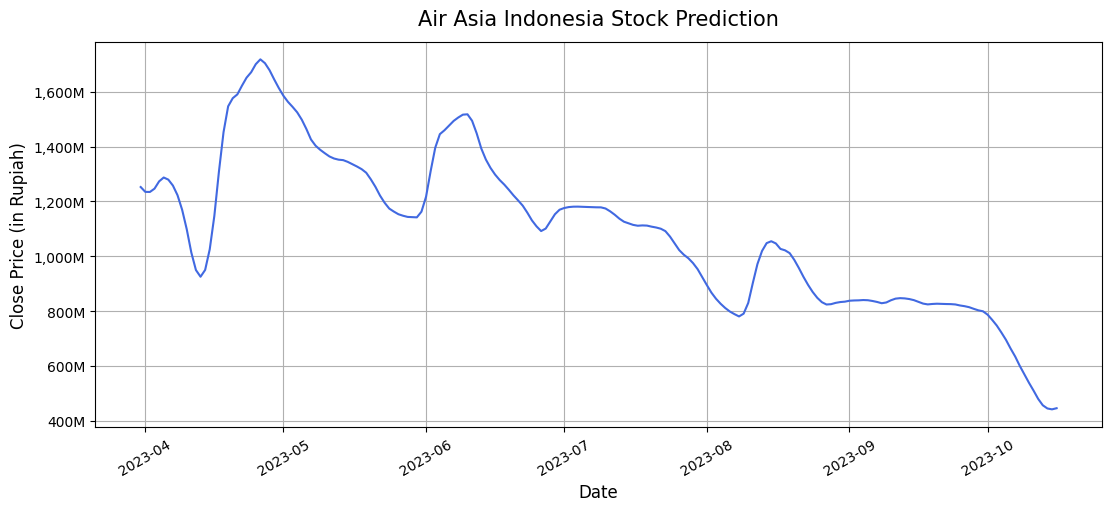

In [139]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - RMSProp

In [140]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/cmpp_relu_rmsprop.h5')

Epoch 1/10
24/24 [==============================] - 19s 511ms/step - loss: 0.0052 - val_loss: 8.0049e-04
Epoch 2/10
24/24 [==============================] - 11s 458ms/step - loss: 0.0026 - val_loss: 0.0011
Epoch 3/10
24/24 [==============================] - 11s 463ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 4/10
24/24 [==============================] - 11s 476ms/step - loss: 0.0019 - val_loss: 6.4817e-04
Epoch 5/10
24/24 [==============================] - 11s 466ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 6/10
24/24 [==============================] - 11s 464ms/step - loss: 0.0019 - val_loss: 6.0361e-04
Epoch 7/10
24/24 [==============================] - 11s 470ms/step - loss: 0.0015 - val_loss: 5.9460e-04
Epoch 8/10
24/24 [==============================] - 11s 467ms/step - loss: 0.0017 - val_loss: 9.9920e-04
Epoch 9/10
24/24 [==============================] - 11s 480ms/step - loss: 0.0016 - val_loss: 5.5904e-04
Epoch 10/10
24/24 [==============================] - 11s 471ms/step

In [141]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)  

8/8 [==============================] - 2s 46ms/step
Mean Absolute Error (MAE): 0.0184314
Mean Absolute Percentage Error (MAPE): 0.15146
Root Mean Squared Error (RMSE): 0.02227
Mean Squared Error (MSE): 0.0004958
R-Squared (R2): 0.915934
T-Statistic 0.6897
P-Value 1.0833825205089953e-20
Elapsed Time (min): 121.12


7/7 [==============================] - 0s 60ms/step


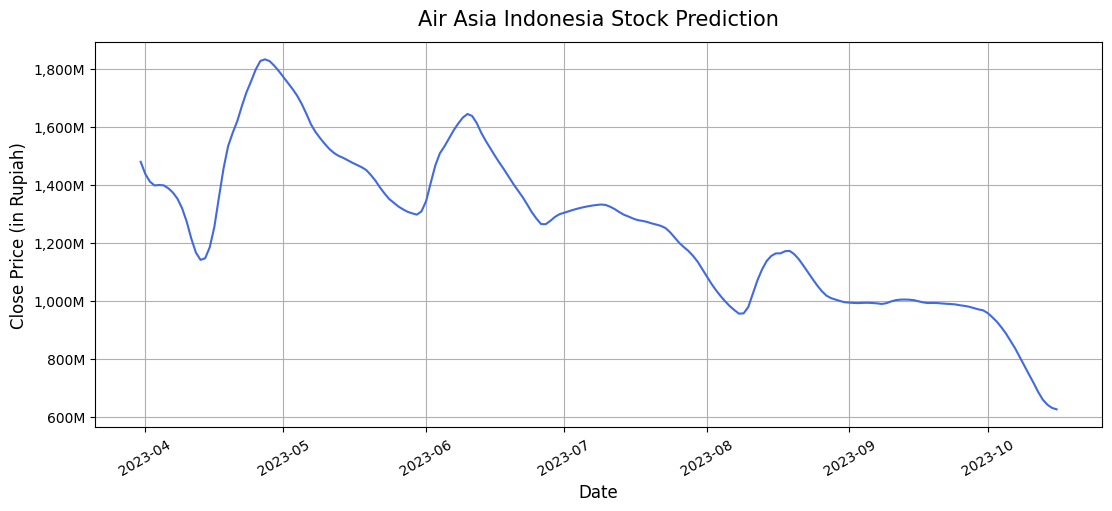

In [142]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - AdaDelta

In [143]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/cmpp_relu_adadelta.h5')

Epoch 1/10
24/24 [==============================] - 18s 445ms/step - loss: 0.0221 - val_loss: 0.0108
Epoch 2/10
24/24 [==============================] - 10s 406ms/step - loss: 0.0220 - val_loss: 0.0106
Epoch 3/10
24/24 [==============================] - 10s 417ms/step - loss: 0.0220 - val_loss: 0.0105
Epoch 4/10
24/24 [==============================] - 11s 440ms/step - loss: 0.0219 - val_loss: 0.0104
Epoch 5/10
24/24 [==============================] - 10s 432ms/step - loss: 0.0216 - val_loss: 0.0102
Epoch 6/10
24/24 [==============================] - 11s 443ms/step - loss: 0.0215 - val_loss: 0.0101
Epoch 7/10
24/24 [==============================] - 10s 429ms/step - loss: 0.0214 - val_loss: 0.0100
Epoch 8/10
24/24 [==============================] - 10s 430ms/step - loss: 0.0213 - val_loss: 0.0098
Epoch 9/10
24/24 [==============================] - 10s 436ms/step - loss: 0.0211 - val_loss: 0.0097
Epoch 10/10
24/24 [==============================] - 11s 481ms/step - loss: 0.0210 - val_lo

In [144]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)  

8/8 [==============================] - 3s 61ms/step
Mean Absolute Error (MAE): 0.1294893
Mean Absolute Percentage Error (MAPE): 0.93195
Root Mean Squared Error (RMSE): 0.14973
Mean Squared Error (MSE): 0.0224197
R-Squared (R2): -2.801469
T-Statistic 0.6289
P-Value 2.0419014510259988e-22
Elapsed Time (min): 112.97


7/7 [==============================] - 0s 60ms/step


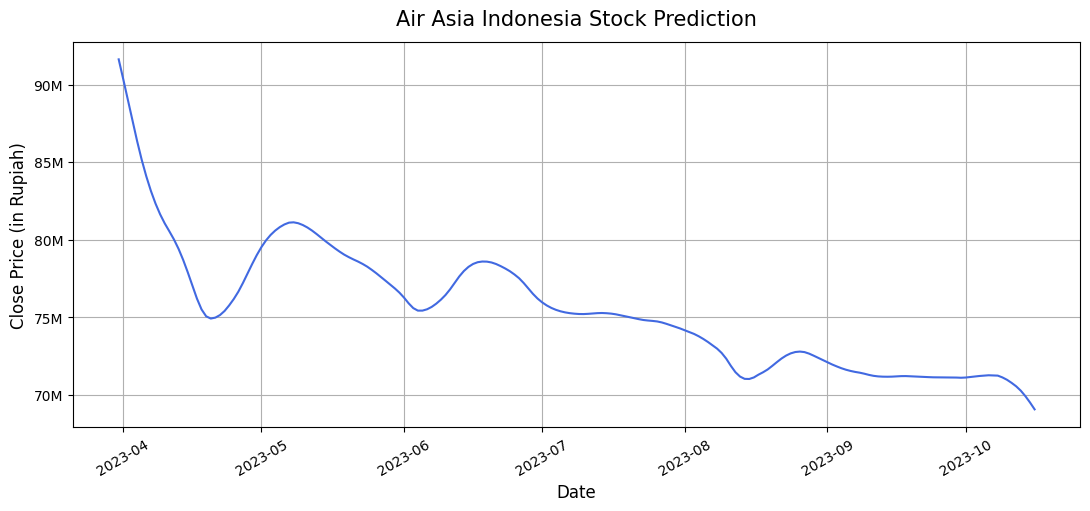

In [145]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - SGD

In [146]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/cmpp_relu_sgd.h5')

Epoch 1/10
24/24 [==============================] - 17s 436ms/step - loss: 0.0122 - val_loss: 0.0011
Epoch 2/10
24/24 [==============================] - 9s 355ms/step - loss: 0.0095 - val_loss: 9.9726e-04
Epoch 3/10
24/24 [==============================] - 9s 355ms/step - loss: 0.0091 - val_loss: 0.0010
Epoch 4/10
24/24 [==============================] - 9s 372ms/step - loss: 0.0090 - val_loss: 9.9667e-04
Epoch 5/10
24/24 [==============================] - 9s 365ms/step - loss: 0.0089 - val_loss: 9.8754e-04
Epoch 6/10
24/24 [==============================] - 9s 394ms/step - loss: 0.0085 - val_loss: 9.8446e-04
Epoch 7/10
24/24 [==============================] - 9s 372ms/step - loss: 0.0084 - val_loss: 9.8188e-04
Epoch 8/10
24/24 [==============================] - 9s 362ms/step - loss: 0.0083 - val_loss: 9.7935e-04
Epoch 9/10
24/24 [==============================] - 9s 378ms/step - loss: 0.0079 - val_loss: 9.8099e-04
Epoch 10/10
24/24 [==============================] - 9s 374ms/step - lo

In [147]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 50ms/step
Mean Absolute Error (MAE): 0.0372071
Mean Absolute Percentage Error (MAPE): 0.22589
Root Mean Squared Error (RMSE): 0.06502
Mean Squared Error (MSE): 0.0042278
R-Squared (R2): 0.283142
T-Statistic 0.6807
P-Value 5.8030880107464665e-21
Elapsed Time (min): 98.96


7/7 [==============================] - 0s 49ms/step


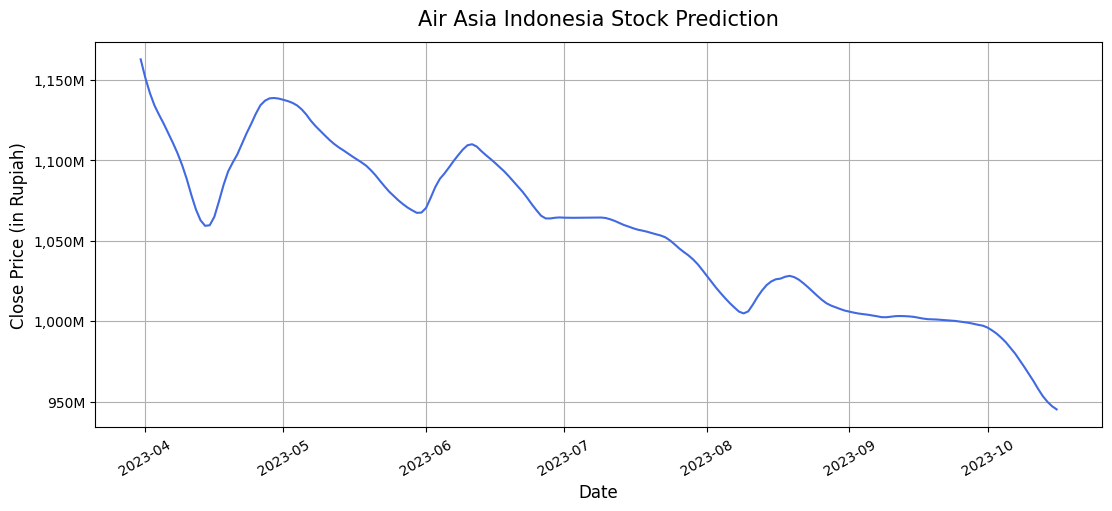

In [148]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - AdaMax

In [149]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/cmpp_relu_adamax.h5')

Epoch 1/10
24/24 [==============================] - 20s 485ms/step - loss: 0.0042 - val_loss: 8.3432e-04
Epoch 2/10
24/24 [==============================] - 11s 468ms/step - loss: 0.0021 - val_loss: 7.3546e-04
Epoch 3/10
24/24 [==============================] - 11s 461ms/step - loss: 0.0017 - val_loss: 7.0489e-04
Epoch 4/10
24/24 [==============================] - 11s 463ms/step - loss: 0.0020 - val_loss: 8.0918e-04
Epoch 5/10
24/24 [==============================] - 11s 454ms/step - loss: 0.0017 - val_loss: 7.7731e-04
Epoch 6/10
24/24 [==============================] - 11s 462ms/step - loss: 0.0015 - val_loss: 6.2015e-04
Epoch 7/10
24/24 [==============================] - 11s 449ms/step - loss: 0.0016 - val_loss: 6.5728e-04
Epoch 8/10
24/24 [==============================] - 11s 476ms/step - loss: 0.0014 - val_loss: 5.7247e-04
Epoch 9/10
24/24 [==============================] - 11s 448ms/step - loss: 0.0015 - val_loss: 6.3715e-04
Epoch 10/10
24/24 [==============================] - 11

In [150]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 56ms/step
Mean Absolute Error (MAE): 0.0122212
Mean Absolute Percentage Error (MAPE): 0.09055
Root Mean Squared Error (RMSE): 0.01781
Mean Squared Error (MSE): 0.0003171
R-Squared (R2): 0.946239
T-Statistic 0.6947
P-Value 1.535950158860376e-20
Elapsed Time (min): 120.25


7/7 [==============================] - 0s 59ms/step


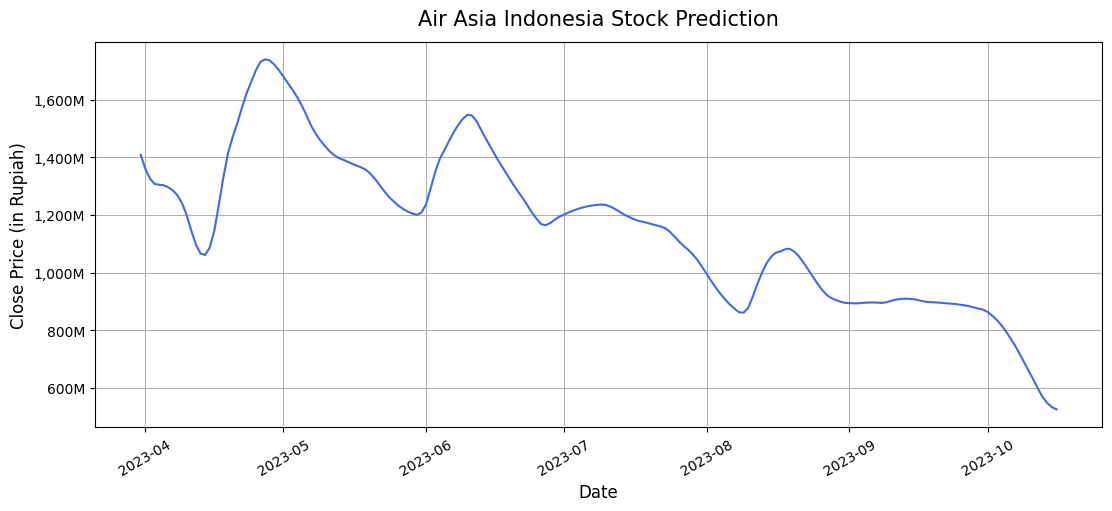

In [151]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - Adam

In [152]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/cmpp_sigmoid_adam.h5')

Epoch 1/10
24/24 [==============================] - 20s 538ms/step - loss: 0.0463 - val_loss: 9.2749e-04
Epoch 2/10
24/24 [==============================] - 11s 453ms/step - loss: 0.0043 - val_loss: 8.7398e-04
Epoch 3/10
24/24 [==============================] - 12s 482ms/step - loss: 0.0026 - val_loss: 8.2676e-04
Epoch 4/10
24/24 [==============================] - 12s 517ms/step - loss: 0.0024 - val_loss: 8.2725e-04
Epoch 5/10
24/24 [==============================] - 12s 487ms/step - loss: 0.0020 - val_loss: 7.4340e-04
Epoch 6/10
24/24 [==============================] - 12s 499ms/step - loss: 0.0017 - val_loss: 7.3241e-04
Epoch 7/10
24/24 [==============================] - 12s 517ms/step - loss: 0.0016 - val_loss: 7.5655e-04
Epoch 8/10
24/24 [==============================] - 12s 481ms/step - loss: 0.0018 - val_loss: 7.3184e-04
Epoch 9/10
24/24 [==============================] - 11s 464ms/step - loss: 0.0015 - val_loss: 6.3616e-04
Epoch 10/10
24/24 [==============================] - 12

In [153]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 63ms/step
Mean Absolute Error (MAE): 0.0113837
Mean Absolute Percentage Error (MAPE): 0.08164
Root Mean Squared Error (RMSE): 0.01672
Mean Squared Error (MSE): 0.0002794
R-Squared (R2): 0.952617
T-Statistic 0.6805
P-Value 5.71020104017366e-21
Elapsed Time (min): 126.7


7/7 [==============================] - 0s 52ms/step


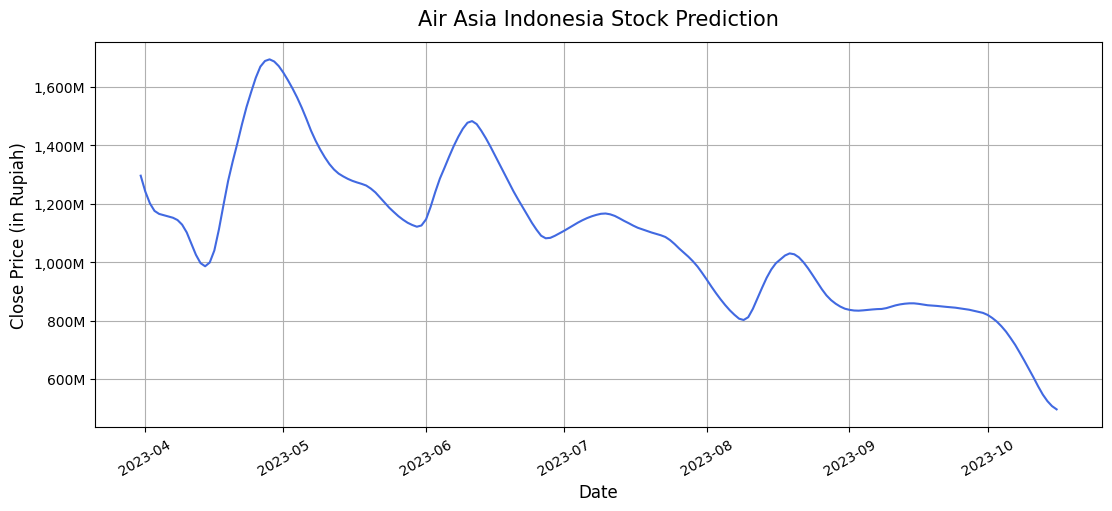

In [154]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - AdaGrad

In [155]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/cmpp_sigmoid_adagrad.h5')

Epoch 1/10
24/24 [==============================] - 18s 478ms/step - loss: 0.0118 - val_loss: 0.0013
Epoch 2/10
24/24 [==============================] - 10s 408ms/step - loss: 0.0110 - val_loss: 0.0011
Epoch 3/10
24/24 [==============================] - 10s 417ms/step - loss: 0.0110 - val_loss: 0.0011
Epoch 4/10
24/24 [==============================] - 10s 397ms/step - loss: 0.0110 - val_loss: 0.0011
Epoch 5/10
24/24 [==============================] - 10s 400ms/step - loss: 0.0109 - val_loss: 0.0011
Epoch 6/10
24/24 [==============================] - 9s 379ms/step - loss: 0.0109 - val_loss: 0.0011
Epoch 7/10
24/24 [==============================] - 9s 393ms/step - loss: 0.0110 - val_loss: 0.0011
Epoch 8/10
24/24 [==============================] - 10s 416ms/step - loss: 0.0109 - val_loss: 0.0011
Epoch 9/10
24/24 [==============================] - 10s 418ms/step - loss: 0.0109 - val_loss: 0.0011
Epoch 10/10
24/24 [==============================] - 10s 433ms/step - loss: 0.0109 - val_loss

In [156]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 66ms/step
Mean Absolute Error (MAE): 0.0472191
Mean Absolute Percentage Error (MAPE): 0.2799
Root Mean Squared Error (RMSE): 0.08316
Mean Squared Error (MSE): 0.0069161
R-Squared (R2): -0.172683
T-Statistic 0.6838
P-Value 7.188840103384399e-21
Elapsed Time (min): 106.56


7/7 [==============================] - 0s 55ms/step


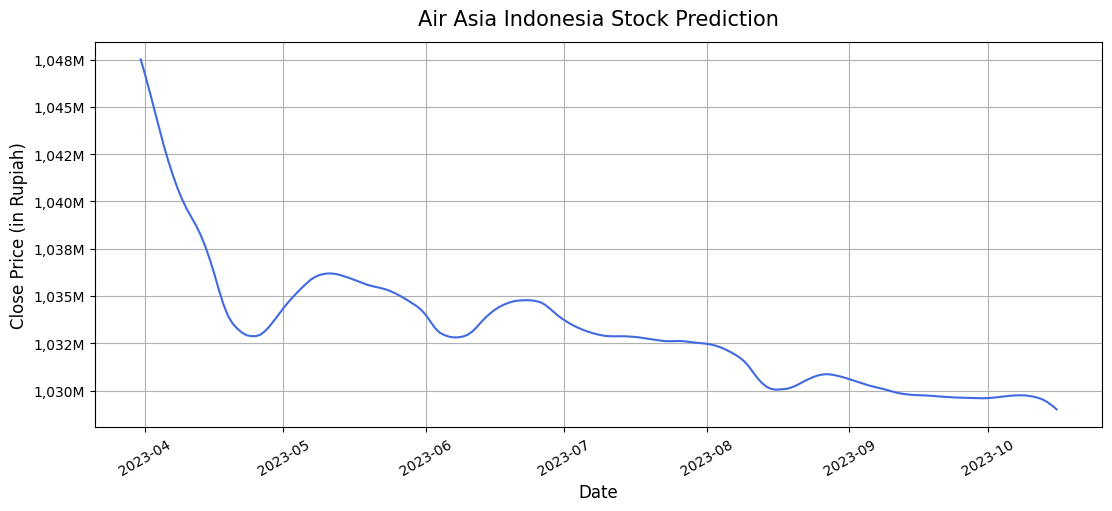

In [157]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - Nadam

In [158]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/cmpp_sigmoid_nadam.h5')

Epoch 1/10
24/24 [==============================] - 19s 427ms/step - loss: 0.2720 - val_loss: 0.0010
Epoch 2/10
24/24 [==============================] - 10s 412ms/step - loss: 0.0127 - val_loss: 9.9200e-04
Epoch 3/10
24/24 [==============================] - 11s 450ms/step - loss: 0.0097 - val_loss: 0.0013
Epoch 4/10
24/24 [==============================] - 10s 416ms/step - loss: 0.0073 - val_loss: 8.7605e-04
Epoch 5/10
24/24 [==============================] - 10s 419ms/step - loss: 0.0058 - val_loss: 8.5369e-04
Epoch 6/10
24/24 [==============================] - 10s 397ms/step - loss: 0.0054 - val_loss: 8.9226e-04
Epoch 7/10
24/24 [==============================] - 10s 409ms/step - loss: 0.0046 - val_loss: 0.0017
Epoch 8/10
24/24 [==============================] - 10s 432ms/step - loss: 0.0043 - val_loss: 7.9576e-04
Epoch 9/10
24/24 [==============================] - 10s 423ms/step - loss: 0.0041 - val_loss: 7.7286e-04
Epoch 10/10
24/24 [==============================] - 10s 431ms/step

In [159]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 52ms/step
Mean Absolute Error (MAE): 0.0262671
Mean Absolute Percentage Error (MAPE): 0.1897
Root Mean Squared Error (RMSE): 0.03657
Mean Squared Error (MSE): 0.0013371
R-Squared (R2): 0.773279
T-Statistic 0.6604
P-Value 1.4905988508661626e-21
Elapsed Time (min): 110.99


7/7 [==============================] - 0s 47ms/step


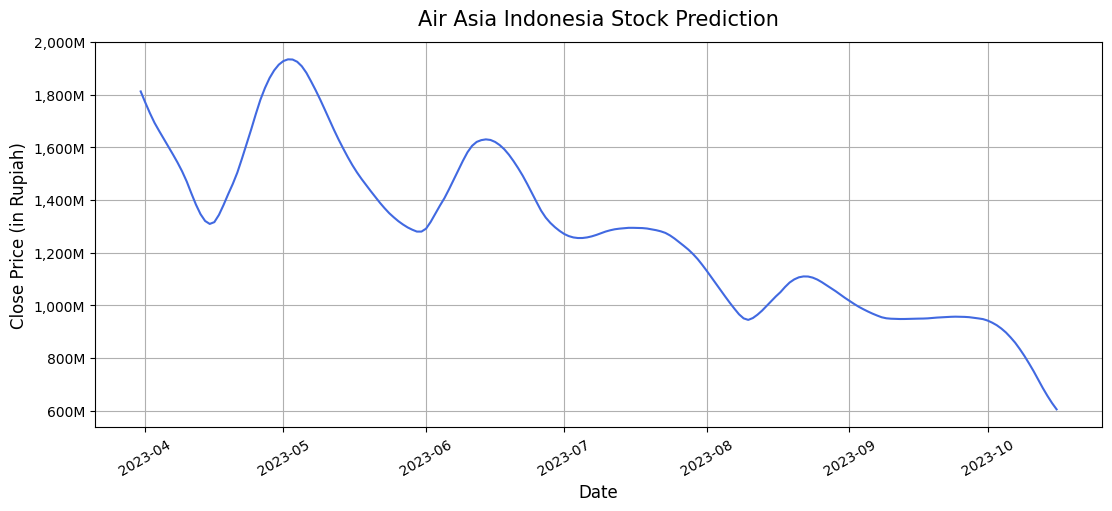

In [160]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - RMSProp

In [161]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/cmpp_sigmoid_rmsprop.h5')

Epoch 1/10
24/24 [==============================] - 19s 497ms/step - loss: 0.0082 - val_loss: 0.0010
Epoch 2/10
24/24 [==============================] - 11s 473ms/step - loss: 0.0037 - val_loss: 0.0011
Epoch 3/10
24/24 [==============================] - 11s 460ms/step - loss: 0.0028 - val_loss: 0.0019
Epoch 4/10
24/24 [==============================] - 12s 494ms/step - loss: 0.0027 - val_loss: 0.0010
Epoch 5/10
24/24 [==============================] - 12s 486ms/step - loss: 0.0024 - val_loss: 0.0010
Epoch 6/10
24/24 [==============================] - 11s 453ms/step - loss: 0.0021 - val_loss: 0.0027
Epoch 7/10
24/24 [==============================] - 11s 437ms/step - loss: 0.0019 - val_loss: 0.0010
Epoch 8/10
24/24 [==============================] - 11s 451ms/step - loss: 0.0019 - val_loss: 7.8266e-04
Epoch 9/10
24/24 [==============================] - 11s 442ms/step - loss: 0.0018 - val_loss: 7.8564e-04
Epoch 10/10
24/24 [==============================] - 12s 484ms/step - loss: 0.0019 

In [162]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 3s 77ms/step
Mean Absolute Error (MAE): 0.0332332
Mean Absolute Percentage Error (MAPE): 0.27776
Root Mean Squared Error (RMSE): 0.03734
Mean Squared Error (MSE): 0.001394
R-Squared (R2): 0.763629
T-Statistic 0.6396
P-Value 3.95962130187632e-22
Elapsed Time (min): 119.66


7/7 [==============================] - 0s 68ms/step


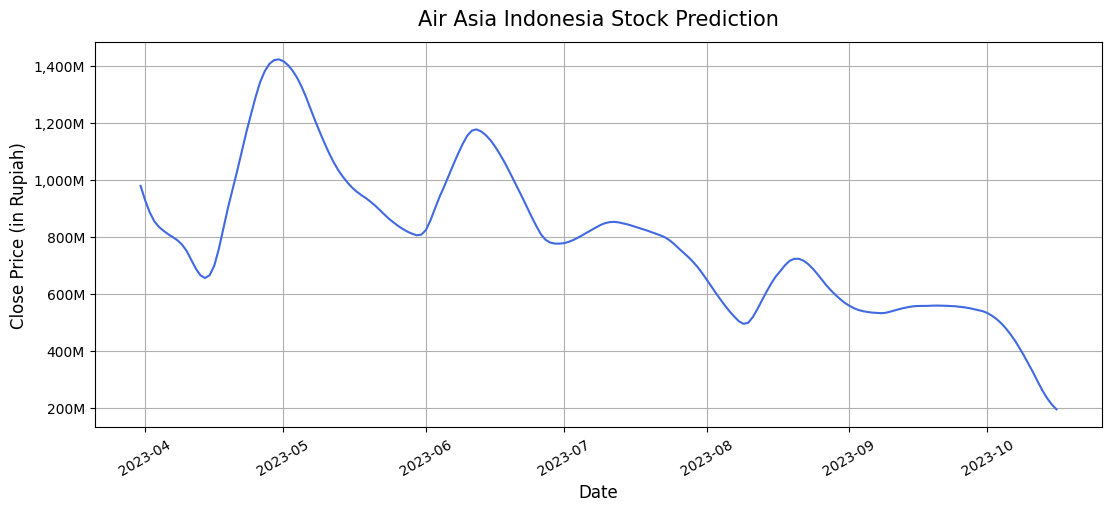

In [163]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - AdaDelta

In [164]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/cmpp_sigmoid_adadelta.h5')

Epoch 1/10
24/24 [==============================] - 21s 516ms/step - loss: 0.0869 - val_loss: 0.0794
Epoch 2/10
24/24 [==============================] - 10s 428ms/step - loss: 0.0865 - val_loss: 0.0790
Epoch 3/10
24/24 [==============================] - 11s 449ms/step - loss: 0.0860 - val_loss: 0.0785
Epoch 4/10
24/24 [==============================] - 12s 481ms/step - loss: 0.0855 - val_loss: 0.0780
Epoch 5/10
24/24 [==============================] - 11s 451ms/step - loss: 0.0850 - val_loss: 0.0775
Epoch 6/10
24/24 [==============================] - 10s 416ms/step - loss: 0.0845 - val_loss: 0.0769
Epoch 7/10
24/24 [==============================] - 10s 423ms/step - loss: 0.0840 - val_loss: 0.0764
Epoch 8/10
24/24 [==============================] - 10s 412ms/step - loss: 0.0835 - val_loss: 0.0759
Epoch 9/10
24/24 [==============================] - 10s 429ms/step - loss: 0.0829 - val_loss: 0.0753
Epoch 10/10
24/24 [==============================] - 10s 423ms/step - loss: 0.0824 - val_lo

In [165]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 45ms/step
Mean Absolute Error (MAE): 0.2384949
Mean Absolute Percentage Error (MAPE): 2.26155
Root Mean Squared Error (RMSE): 0.24615
Mean Squared Error (MSE): 0.0605894
R-Squared (R2): -9.273472
T-Statistic 0.6763
P-Value 4.305284852953493e-21
Elapsed Time (min): 115.49


7/7 [==============================] - 0s 46ms/step


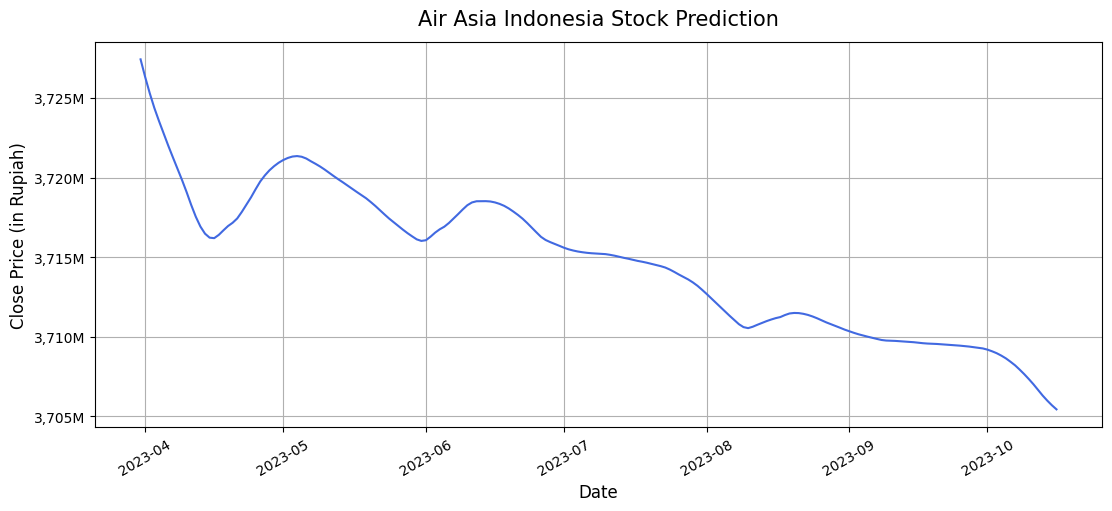

In [166]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - SGD

In [167]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/cmpp_sigmoid_sgd.h5')

Epoch 1/10
24/24 [==============================] - 20s 510ms/step - loss: 0.0236 - val_loss: 0.0012
Epoch 2/10
24/24 [==============================] - 11s 459ms/step - loss: 0.0111 - val_loss: 0.0012
Epoch 3/10
24/24 [==============================] - 11s 454ms/step - loss: 0.0110 - val_loss: 0.0011
Epoch 4/10
24/24 [==============================] - 11s 471ms/step - loss: 0.0109 - val_loss: 0.0011
Epoch 5/10
24/24 [==============================] - 11s 454ms/step - loss: 0.0109 - val_loss: 0.0011
Epoch 6/10
24/24 [==============================] - 11s 474ms/step - loss: 0.0109 - val_loss: 0.0011
Epoch 7/10
24/24 [==============================] - 11s 459ms/step - loss: 0.0109 - val_loss: 0.0012
Epoch 8/10
24/24 [==============================] - 11s 477ms/step - loss: 0.0109 - val_loss: 0.0011
Epoch 9/10
24/24 [==============================] - 11s 461ms/step - loss: 0.0108 - val_loss: 0.0011
Epoch 10/10
24/24 [==============================] - 12s 512ms/step - loss: 0.0108 - val_lo

In [168]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 45ms/step
Mean Absolute Error (MAE): 0.0471479
Mean Absolute Percentage Error (MAPE): 0.27893
Root Mean Squared Error (RMSE): 0.0828
Mean Squared Error (MSE): 0.0068557
R-Squared (R2): -0.162437
T-Statistic 0.647
P-Value 6.313430276891037e-22
Elapsed Time (min): 121.86


7/7 [==============================] - 0s 45ms/step


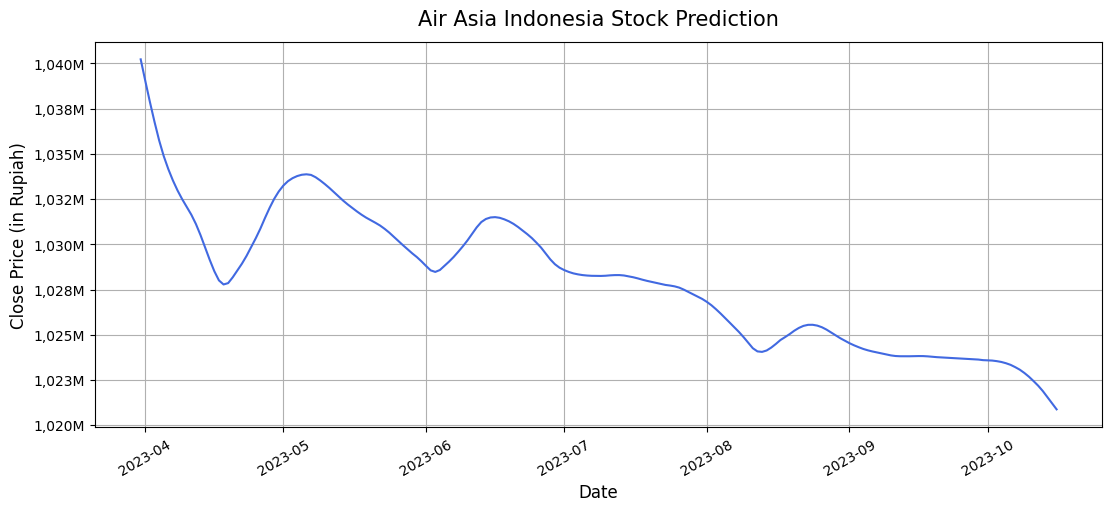

In [169]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - AdaMax

In [170]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/cmpp_sigmoid_adamax.h5')

Epoch 1/10
24/24 [==============================] - 15s 369ms/step - loss: 0.0059 - val_loss: 9.1708e-04
Epoch 2/10
24/24 [==============================] - 7s 302ms/step - loss: 0.0025 - val_loss: 9.6573e-04
Epoch 3/10
24/24 [==============================] - 7s 303ms/step - loss: 0.0021 - val_loss: 8.5692e-04
Epoch 4/10
24/24 [==============================] - 7s 304ms/step - loss: 0.0020 - val_loss: 7.6885e-04
Epoch 5/10
24/24 [==============================] - 7s 304ms/step - loss: 0.0017 - val_loss: 8.2600e-04
Epoch 6/10
24/24 [==============================] - 7s 305ms/step - loss: 0.0017 - val_loss: 7.2699e-04
Epoch 7/10
24/24 [==============================] - 8s 317ms/step - loss: 0.0016 - val_loss: 7.0129e-04
Epoch 8/10
24/24 [==============================] - 7s 300ms/step - loss: 0.0015 - val_loss: 7.0079e-04
Epoch 9/10
24/24 [==============================] - 8s 319ms/step - loss: 0.0015 - val_loss: 7.2748e-04
Epoch 10/10
24/24 [==============================] - 8s 325ms/s

In [171]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 40ms/step
Mean Absolute Error (MAE): 0.0172547
Mean Absolute Percentage Error (MAPE): 0.12295
Root Mean Squared Error (RMSE): 0.02438
Mean Squared Error (MSE): 0.0005945
R-Squared (R2): 0.899198
T-Statistic 0.6694
P-Value 2.7021498568953385e-21
Elapsed Time (min): 82.5


7/7 [==============================] - 0s 48ms/step


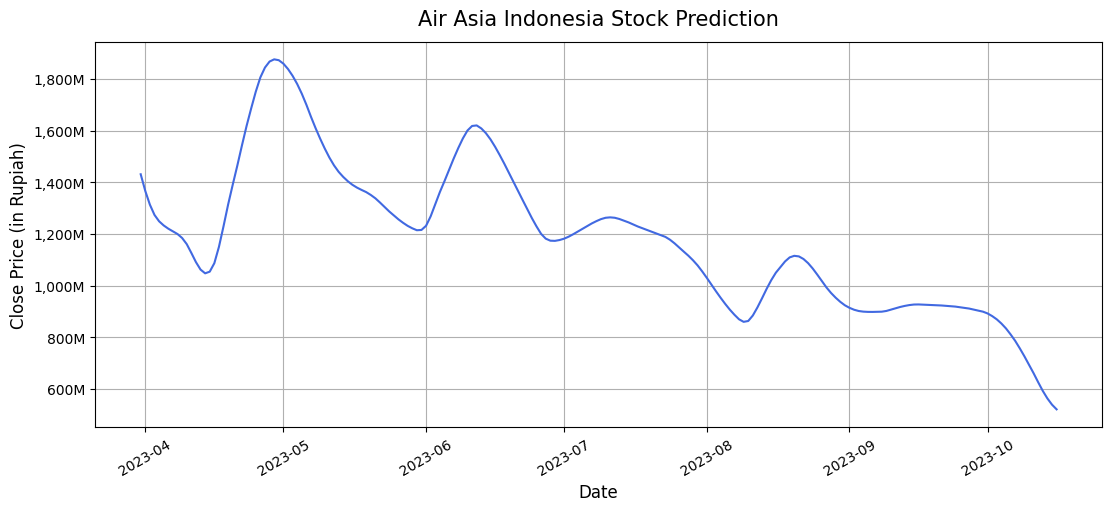

In [172]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - Adam

In [173]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/cmpp_tanh_adam.h5')

Epoch 1/10
24/24 [==============================] - 14s 331ms/step - loss: 0.0045 - val_loss: 0.0015
Epoch 2/10
24/24 [==============================] - 7s 289ms/step - loss: 0.0018 - val_loss: 6.2957e-04
Epoch 3/10
24/24 [==============================] - 7s 279ms/step - loss: 0.0015 - val_loss: 5.5860e-04
Epoch 4/10
24/24 [==============================] - 7s 287ms/step - loss: 0.0015 - val_loss: 5.6871e-04
Epoch 5/10
24/24 [==============================] - 7s 288ms/step - loss: 0.0012 - val_loss: 5.1601e-04
Epoch 6/10
24/24 [==============================] - 7s 285ms/step - loss: 0.0011 - val_loss: 3.8580e-04
Epoch 7/10
24/24 [==============================] - 7s 288ms/step - loss: 9.6090e-04 - val_loss: 3.7405e-04
Epoch 8/10
24/24 [==============================] - 7s 290ms/step - loss: 8.8474e-04 - val_loss: 3.3586e-04
Epoch 9/10
24/24 [==============================] - 7s 293ms/step - loss: 7.8999e-04 - val_loss: 3.3629e-04
Epoch 10/10
24/24 [==============================] - 7s

In [174]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 38ms/step
Mean Absolute Error (MAE): 0.0143202
Mean Absolute Percentage Error (MAPE): 0.0922
Root Mean Squared Error (RMSE): 0.02252
Mean Squared Error (MSE): 0.000507
R-Squared (R2): 0.914033
T-Statistic 0.7041
P-Value 3.028858491534438e-20
Elapsed Time (min): 77.37


7/7 [==============================] - 0s 39ms/step


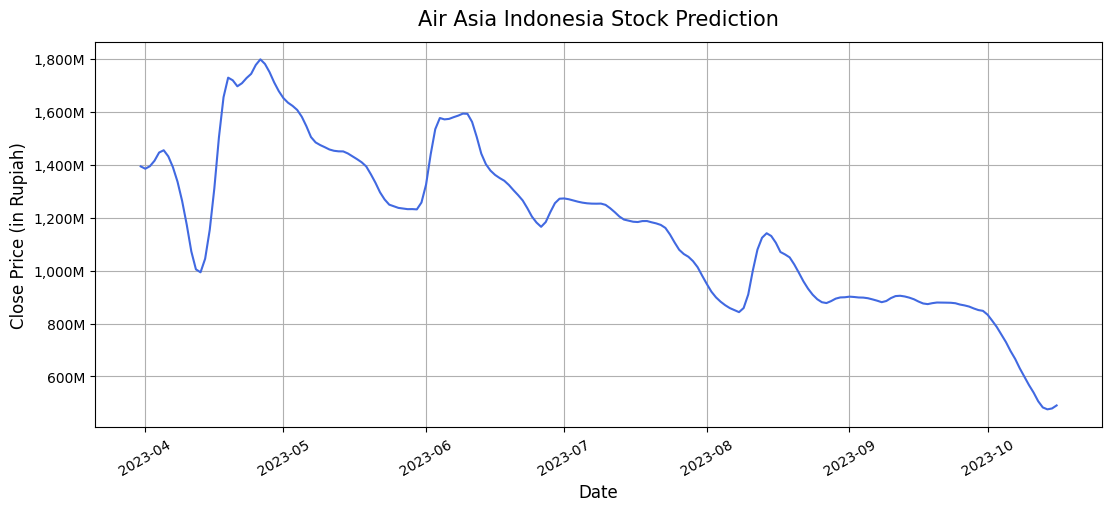

In [175]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - AdaGrad

In [176]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/cmpp_tanh_adagrad.h5')

Epoch 1/10
24/24 [==============================] - 16s 384ms/step - loss: 0.0128 - val_loss: 0.0019
Epoch 2/10
24/24 [==============================] - 8s 332ms/step - loss: 0.0095 - val_loss: 0.0011
Epoch 3/10
24/24 [==============================] - 8s 324ms/step - loss: 0.0090 - val_loss: 9.9655e-04
Epoch 4/10
24/24 [==============================] - 8s 330ms/step - loss: 0.0088 - val_loss: 9.9448e-04
Epoch 5/10
24/24 [==============================] - 8s 334ms/step - loss: 0.0087 - val_loss: 9.9659e-04
Epoch 6/10
24/24 [==============================] - 8s 339ms/step - loss: 0.0085 - val_loss: 9.9780e-04
Epoch 7/10
24/24 [==============================] - 8s 334ms/step - loss: 0.0084 - val_loss: 9.9698e-04
Epoch 8/10
24/24 [==============================] - 8s 352ms/step - loss: 0.0085 - val_loss: 9.9386e-04
Epoch 9/10
24/24 [==============================] - 8s 336ms/step - loss: 0.0080 - val_loss: 9.9537e-04
Epoch 10/10
24/24 [==============================] - 9s 356ms/step - lo

In [177]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 41ms/step
Mean Absolute Error (MAE): 0.0369543
Mean Absolute Percentage Error (MAPE): 0.22637
Root Mean Squared Error (RMSE): 0.06437
Mean Squared Error (MSE): 0.0041433
R-Squared (R2): 0.297473
T-Statistic 0.6661
P-Value 2.1783732769130793e-21
Elapsed Time (min): 89.88


7/7 [==============================] - 0s 40ms/step


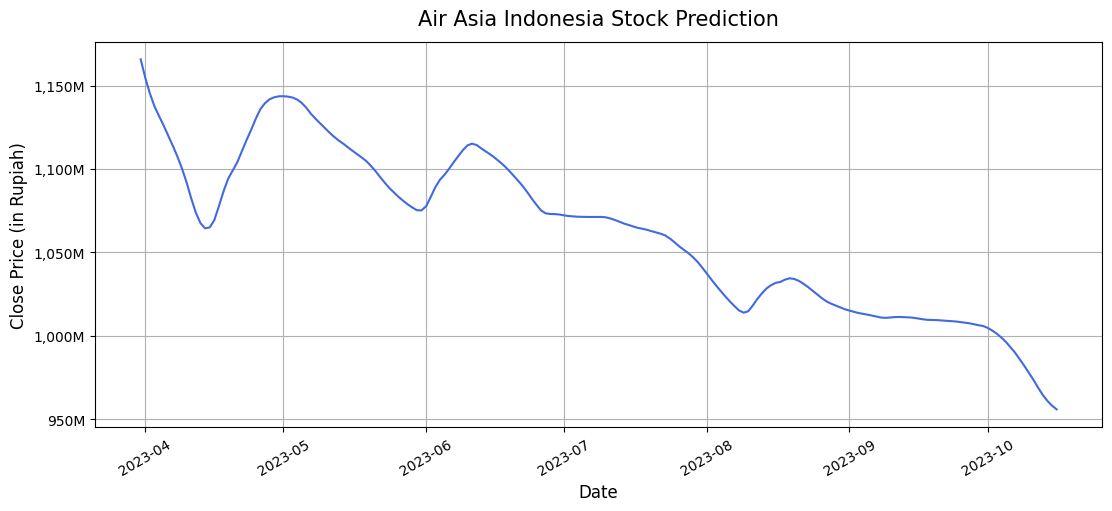

In [178]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - Nadam

In [179]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/cmpp_tanh_nadam.h5')

Epoch 1/10
24/24 [==============================] - 16s 354ms/step - loss: 0.0044 - val_loss: 7.9162e-04
Epoch 2/10
24/24 [==============================] - 8s 315ms/step - loss: 0.0016 - val_loss: 7.2111e-04
Epoch 3/10
24/24 [==============================] - 8s 318ms/step - loss: 0.0014 - val_loss: 6.0796e-04
Epoch 4/10
24/24 [==============================] - 8s 318ms/step - loss: 0.0012 - val_loss: 5.0078e-04
Epoch 5/10
24/24 [==============================] - 8s 329ms/step - loss: 0.0011 - val_loss: 4.2898e-04
Epoch 6/10
24/24 [==============================] - 8s 326ms/step - loss: 0.0010 - val_loss: 4.0421e-04
Epoch 7/10
24/24 [==============================] - 8s 332ms/step - loss: 9.8286e-04 - val_loss: 3.5554e-04
Epoch 8/10
24/24 [==============================] - 8s 323ms/step - loss: 9.6473e-04 - val_loss: 3.6307e-04
Epoch 9/10
24/24 [==============================] - 8s 329ms/step - loss: 8.0171e-04 - val_loss: 2.9701e-04
Epoch 10/10
24/24 [==============================] 

In [180]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 42ms/step
Mean Absolute Error (MAE): 0.0120772
Mean Absolute Percentage Error (MAPE): 0.09287
Root Mean Squared Error (RMSE): 0.01608
Mean Squared Error (MSE): 0.0002585
R-Squared (R2): 0.956175
T-Statistic 0.7078
P-Value 3.9519096601997885e-20
Elapsed Time (min): 87.29


7/7 [==============================] - 0s 40ms/step


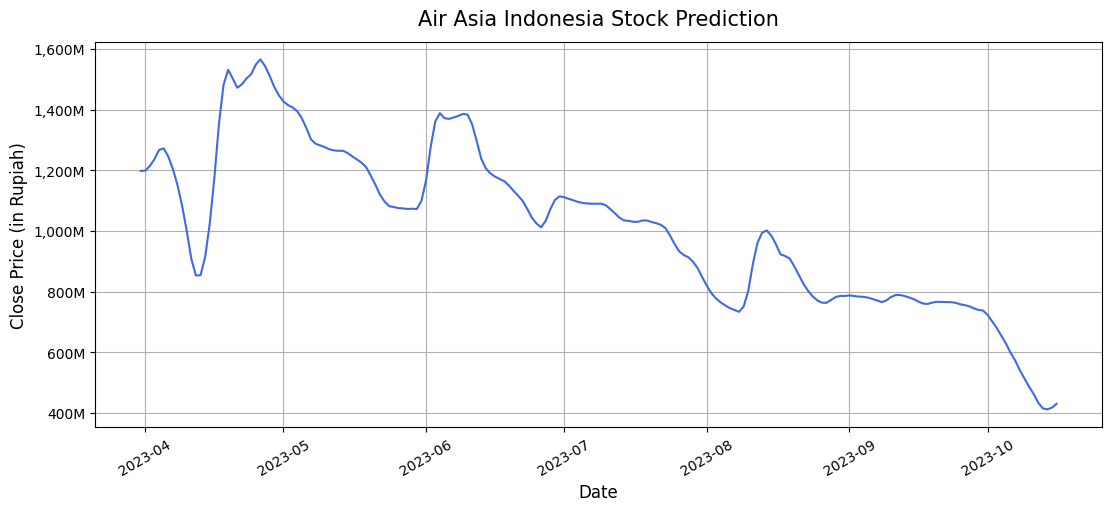

In [181]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - RMSProp

In [182]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/cmpp_tanh_rmsprop.h5')

Epoch 1/10
24/24 [==============================] - 16s 409ms/step - loss: 0.0046 - val_loss: 7.5069e-04
Epoch 2/10
24/24 [==============================] - 9s 366ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 3/10
24/24 [==============================] - 8s 352ms/step - loss: 0.0020 - val_loss: 6.1995e-04
Epoch 4/10
24/24 [==============================] - 9s 371ms/step - loss: 0.0019 - val_loss: 5.8318e-04
Epoch 5/10
24/24 [==============================] - 9s 358ms/step - loss: 0.0016 - val_loss: 5.6380e-04
Epoch 6/10
24/24 [==============================] - 9s 370ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 7/10
24/24 [==============================] - 9s 381ms/step - loss: 0.0014 - val_loss: 9.5098e-04
Epoch 8/10
24/24 [==============================] - 9s 369ms/step - loss: 0.0015 - val_loss: 6.4995e-04
Epoch 9/10
24/24 [==============================] - 9s 379ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 10/10
24/24 [==============================] - 9s 379ms/step - loss: 

In [183]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 40ms/step
Mean Absolute Error (MAE): 0.0130281
Mean Absolute Percentage Error (MAPE): 0.0974
Root Mean Squared Error (RMSE): 0.01741
Mean Squared Error (MSE): 0.0003032
R-Squared (R2): 0.948582
T-Statistic 0.6836
P-Value 7.101696948969364e-21
Elapsed Time (min): 96.59


7/7 [==============================] - 0s 41ms/step


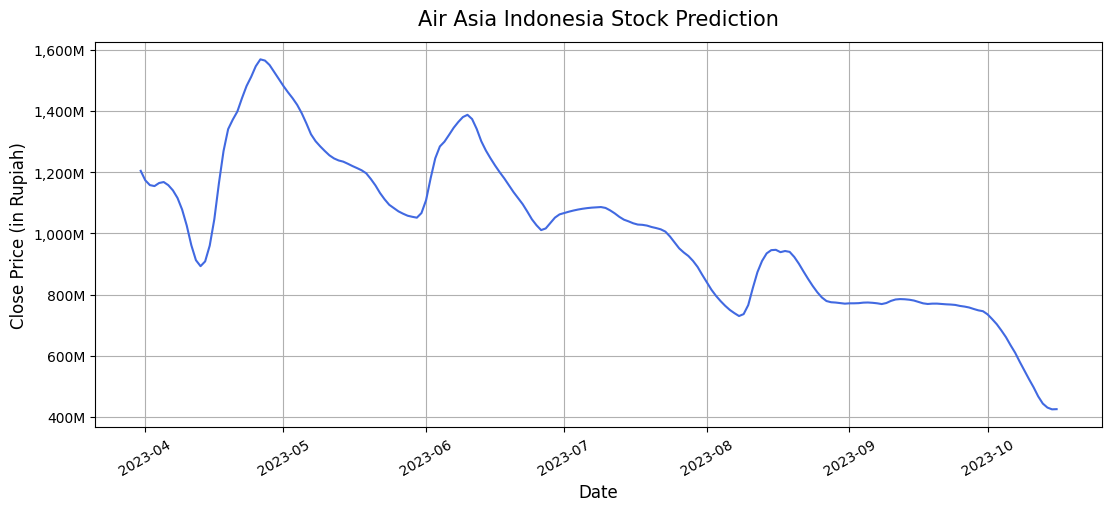

In [184]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - AdaDelta

In [185]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/cmpp_tanh_adadelta.h5')

Epoch 1/10
24/24 [==============================] - 16s 378ms/step - loss: 0.0246 - val_loss: 0.0121
Epoch 2/10
24/24 [==============================] - 8s 328ms/step - loss: 0.0243 - val_loss: 0.0119
Epoch 3/10
24/24 [==============================] - 8s 342ms/step - loss: 0.0242 - val_loss: 0.0117
Epoch 4/10
24/24 [==============================] - 8s 347ms/step - loss: 0.0238 - val_loss: 0.0114
Epoch 5/10
24/24 [==============================] - 8s 344ms/step - loss: 0.0236 - val_loss: 0.0112
Epoch 6/10
24/24 [==============================] - 9s 358ms/step - loss: 0.0235 - val_loss: 0.0110
Epoch 7/10
24/24 [==============================] - 8s 349ms/step - loss: 0.0232 - val_loss: 0.0108
Epoch 8/10
24/24 [==============================] - 9s 356ms/step - loss: 0.0228 - val_loss: 0.0105
Epoch 9/10
24/24 [==============================] - 8s 345ms/step - loss: 0.0225 - val_loss: 0.0103
Epoch 10/10
24/24 [==============================] - 8s 352ms/step - loss: 0.0221 - val_loss: 0.010

In [186]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 40ms/step
Mean Absolute Error (MAE): 0.1373486
Mean Absolute Percentage Error (MAPE): 0.98181
Root Mean Squared Error (RMSE): 0.16022
Mean Squared Error (MSE): 0.0256706
R-Squared (R2): -3.352677
T-Statistic 0.6484
P-Value 6.891946785989022e-22
Elapsed Time (min): 91.82


7/7 [==============================] - 0s 40ms/step


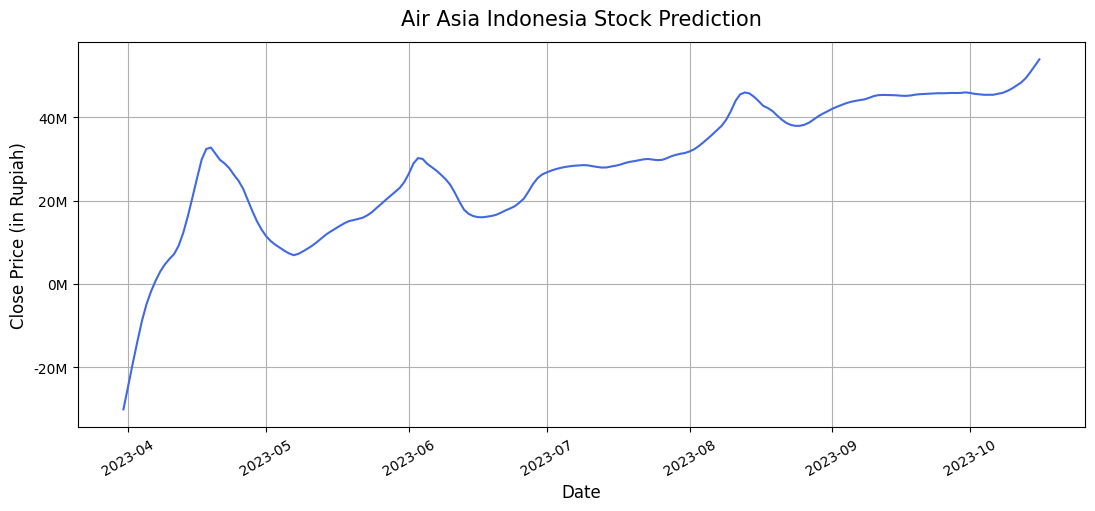

In [187]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - SGD

In [188]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/cmpp_tanh_sgd.h5')

Epoch 1/10
24/24 [==============================] - 15s 358ms/step - loss: 0.0109 - val_loss: 9.9929e-04
Epoch 2/10
24/24 [==============================] - 7s 308ms/step - loss: 0.0092 - val_loss: 9.8438e-04
Epoch 3/10
24/24 [==============================] - 8s 318ms/step - loss: 0.0089 - val_loss: 0.0010
Epoch 4/10
24/24 [==============================] - 8s 316ms/step - loss: 0.0086 - val_loss: 9.7591e-04
Epoch 5/10
24/24 [==============================] - 8s 324ms/step - loss: 0.0082 - val_loss: 9.9248e-04
Epoch 6/10
24/24 [==============================] - 8s 321ms/step - loss: 0.0078 - val_loss: 9.6088e-04
Epoch 7/10
24/24 [==============================] - 8s 315ms/step - loss: 0.0075 - val_loss: 9.5502e-04
Epoch 8/10
24/24 [==============================] - 8s 324ms/step - loss: 0.0073 - val_loss: 9.6465e-04
Epoch 9/10
24/24 [==============================] - 8s 325ms/step - loss: 0.0071 - val_loss: 9.6861e-04
Epoch 10/10
24/24 [==============================] - 8s 327ms/step 

In [189]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 41ms/step
Mean Absolute Error (MAE): 0.0327754
Mean Absolute Percentage Error (MAPE): 0.20161
Root Mean Squared Error (RMSE): 0.05693
Mean Squared Error (MSE): 0.0032411
R-Squared (R2): 0.450447
T-Statistic 0.6756
P-Value 4.091238944758326e-21
Elapsed Time (min): 84.86


7/7 [==============================] - 0s 48ms/step


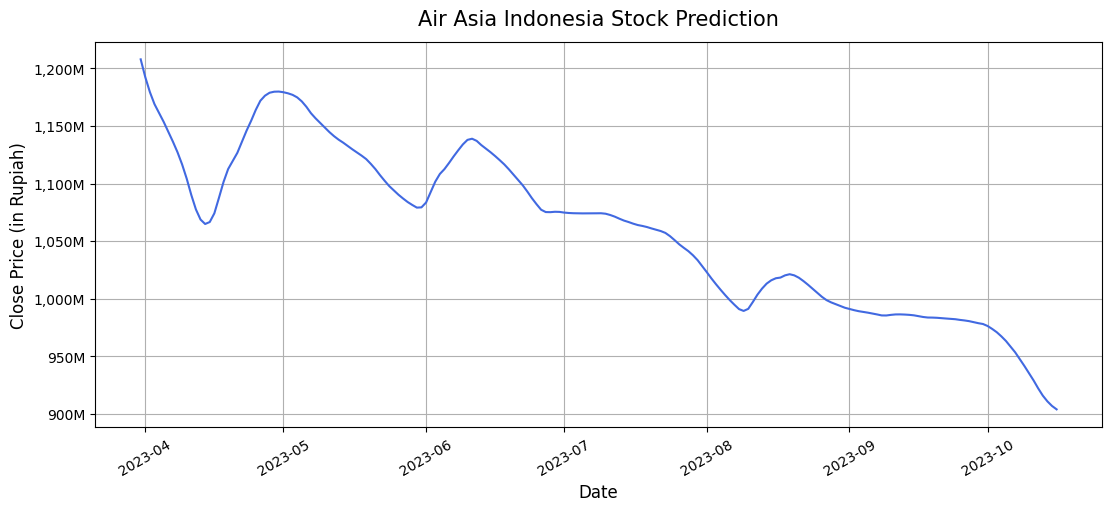

In [190]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - AdaMax

In [191]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/cmpp_tanh_adamax.h5')

Epoch 1/10
24/24 [==============================] - 15s 363ms/step - loss: 0.0040 - val_loss: 8.7152e-04
Epoch 2/10
24/24 [==============================] - 8s 317ms/step - loss: 0.0019 - val_loss: 7.3127e-04
Epoch 3/10
24/24 [==============================] - 8s 322ms/step - loss: 0.0018 - val_loss: 8.5513e-04
Epoch 4/10
24/24 [==============================] - 8s 317ms/step - loss: 0.0016 - val_loss: 8.3039e-04
Epoch 5/10
24/24 [==============================] - 8s 323ms/step - loss: 0.0015 - val_loss: 6.2290e-04
Epoch 6/10
24/24 [==============================] - 8s 324ms/step - loss: 0.0014 - val_loss: 6.1498e-04
Epoch 7/10
24/24 [==============================] - 8s 320ms/step - loss: 0.0014 - val_loss: 5.7695e-04
Epoch 8/10
24/24 [==============================] - 8s 340ms/step - loss: 0.0013 - val_loss: 5.8124e-04
Epoch 9/10
24/24 [==============================] - 8s 321ms/step - loss: 0.0014 - val_loss: 5.6531e-04
Epoch 10/10
24/24 [==============================] - 8s 343ms/s

In [192]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 40ms/step
Mean Absolute Error (MAE): 0.0098673
Mean Absolute Percentage Error (MAPE): 0.06988
Root Mean Squared Error (RMSE): 0.01557
Mean Squared Error (MSE): 0.0002425
R-Squared (R2): 0.958882
T-Statistic 0.69
P-Value 1.104135302699343e-20
Elapsed Time (min): 86.5


7/7 [==============================] - 0s 41ms/step


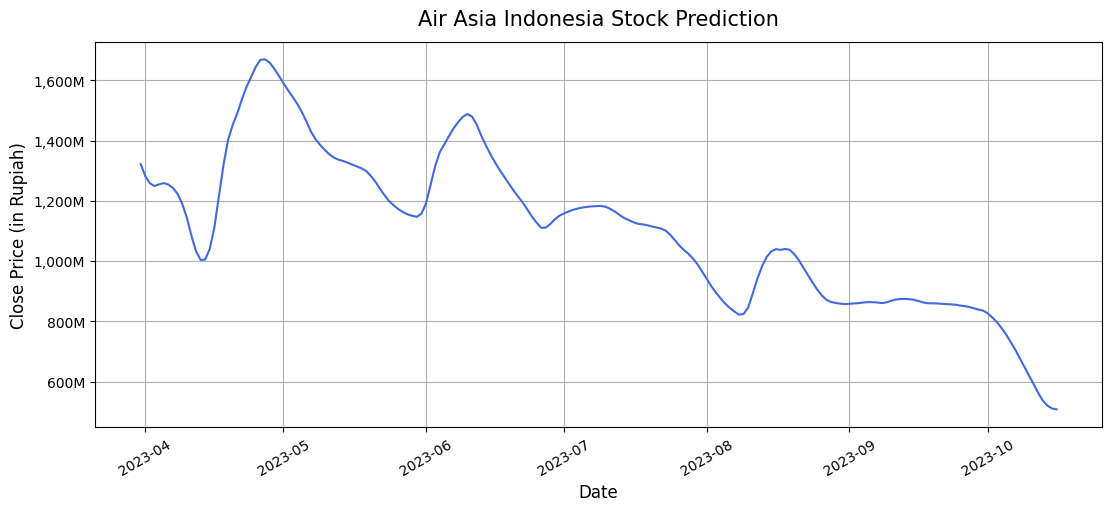

In [193]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Comparison LSTM Model based on Activation and Optimizer Parameter

In [194]:
# Define the activation functions and optimizers to be tested
activations = ['linear', 'relu', 'tanh', 'sigmoid']
optimizers = ['adam', 'adagrad', 'nadam', 'rmsprop', 'adadelta', 'sgd', 'adamax']

# Generate all possible combinations of activation functions and optimizers
combinations = list(itertools.product(activations, optimizers))

# Define a function to build and train an LSTM model with a given activation function and optimizer
def build_model(activations, optimizers):
    model = Sequential()
    model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation=activations))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizers)
    model.fit(X_train, y_train, batch_size=100, epochs=10, validation_split=0.1, verbose=0)
    return model

# Train and evaluate the models for all possible combinations of activation functions and optimizers
import time
results = []
for activations, optimizers in combinations:
    print(f'Training model with {activations} activation and {optimizers} optimizer')
    start_time = time.time()
    model = build_model(activations, optimizers)
    end_time = time.time()
    preds = model.predict(X_test)
    stat, p = stats.shapiro(preds)
    mape = round(metrics.mean_absolute_percentage_error(y_test, preds), 5)
    mae = round(metrics.mean_absolute_error(y_test, preds), 5)
    mse = round(metrics.mean_squared_error(y_test, preds), 5)
    rmse = round(math.sqrt(mse), 5)
    r2 = round(metrics.r2_score(y_test, preds), 2)
    elapsed_time = round(end_time - start_time, 2)
    results.append([activations, optimizers, mape, mae, mse, rmse, r2, elapsed_time, stat, p])

# Create a DataFrame from the results list
df_result = pd.DataFrame(results, columns=['Activation', 'Optimizer', 'MAPE (%)', 'MAE (%)', 
                                           'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'])

# Create a pivot table to compare the results
df_pivot_result = pd.pivot_table(df_result, values=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'], 
                                 index=['Activation', 'Optimizer'])

Training model with linear activation and adam optimizer
8/8 [==============================] - 2s 39ms/step
Training model with linear activation and adagrad optimizer
8/8 [==============================] - 2s 43ms/step
Training model with linear activation and nadam optimizer
8/8 [==============================] - 2s 38ms/step
Training model with linear activation and rmsprop optimizer
8/8 [==============================] - 2s 40ms/step
Training model with linear activation and adadelta optimizer
8/8 [==============================] - 2s 46ms/step
Training model with linear activation and sgd optimizer
8/8 [==============================] - 2s 40ms/step
Training model with linear activation and adamax optimizer
8/8 [==============================] - 2s 42ms/step
Training model with relu activation and adam optimizer
8/8 [==============================] - 2s 41ms/step
Training model with relu activation and adagrad optimizer
8/8 [==============================] - 2s 42ms/step
Training

In [195]:
# Create a DataFrame from the results list
df_result = pd.DataFrame(results, columns=['Activation', 'Optimizer', 'MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'])

# Create a pivot table to compare the results
df_pivot_result = pd.pivot_table(df_result, values=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'], 
                                 index=['Activation', 'Optimizer'])
# Get several LSTM model evaluation 
df_pivot_result.sort_values(by=['Activation', 'Optimizer'], ascending=True)

Elapsed Time (min)  MAE (%)  MAPE (%)  MSE (%)  \
Activation Optimizer                                                   
linear     adadelta                84.01  0.13477   0.96087  0.02488   
           adagrad                 92.64  0.04485   0.26729  0.00619   
           adam                    81.33  0.00997   0.07089  0.00022   
           adamax                  90.49  0.02460   0.21231  0.00077   
           nadam                   82.16  0.00849   0.06070  0.00019   
           rmsprop                 89.14  0.01222   0.08502  0.00032   
           sgd                     83.82  0.03571   0.21625  0.00388   
relu       adadelta               116.39  0.13287   0.95306  0.02383   
           adagrad                114.78  0.03890   0.22925  0.00487   
           adam                   109.98  0.01260   0.08432  0.00040   
           adamax                 109.06  0.01382   0.10036  0.00040   
           nadam                  116.61  0.01089   0.07834  0.00026   
           rmsprop                120.62  0.01726   0.13927  0.00045   
           sgd                    107.30  0.03752   0.22260  0.00435   
sigmoid    adadelta                97.99  0.48585   4.45839  0.24201   
           adagrad                 81.81  0.07839   0.48833  0.01174   
           adam                    88.82  0.01149   0.08146  0.00028   
           adamax                  96.27  0.01845   0.11879  0.00088   
           nadam                   98.32  0.02054   0.15241  0.00084   
           rmsprop                100.22  0.01308   0.09861  0.00035   
           sgd                    102.76  0.04710   0.27962  0.00687   
tanh       adadelta               106.11  0.10197   0.72107  0.01451   
           adagrad                 93.88  0.03866   0.23559  0.00470   
           adam                    96.88  0.00917   0.06386  0.00020   
           adamax                  97.04  0.01060   0.07357  0.00029   
           nadam                  111.42  0.01044   0.06740  0.00031   
           rmsprop                110.47  0.01653   0.11734  0.00062   
           sgd                     91.89  0.03244   0.20112  0.00319   

                           P-Value  R-Squared (%)  RMSE (%)  T-Statistic  
Activation Optimizer                                                      
linear     adadelta   6.060243e-22          -3.22   0.15773     0.646399  
           adagrad    2.709189e-21          -0.05   0.07868     0.669425  
           adam       4.101011e-20           0.96   0.01483     0.708285  
           adamax     8.752725e-21           0.87   0.02775     0.686647  
           nadam      4.945175e-20           0.97   0.01378     0.710829  
           rmsprop    5.159882e-21           0.95   0.01789     0.678972  
           sgd        5.933405e-21           0.34   0.06229     0.681015  
relu       adadelta   4.085704e-22          -3.04   0.15437     0.640139  
           adagrad    4.382410e-18           0.17   0.06979     0.766976  
           adam       5.057283e-20           0.93   0.02000     0.711133  
           adamax     1.414938e-20           0.93   0.02000     0.693502  
           nadam      6.468096e-20           0.96   0.01612     0.714449  
           rmsprop    4.347579e-20           0.92   0.02121     0.709081  
           sgd        3.293559e-20           0.26   0.06595     0.705284  
sigmoid    adadelta   1.001015e-20         -40.04   0.49195     0.688574  
           adagrad    1.119573e-20          -0.99   0.10835     0.690175  
           adam       7.333958e-21           0.95   0.01673     0.684094  
           adamax     8.927731e-22           0.85   0.02966     0.652470  
           nadam      1.966781e-22           0.86   0.02898     0.628307  
           rmsprop    1.555793e-21           0.94   0.01871     0.661033  
           sgd        4.532686e-21          -0.16   0.08289     0.677069  
tanh       adadelta   8.023121e-21          -1.46   0.12046     0.685393  
           adagrad    7.540473e-21           0.20   0.06856  

In [196]:
# Create a DataFrame from the results list
df_result = pd.DataFrame(results, columns=['Activation', 'Optimizer', 'MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'])

# Create a pivot table to compare the results
df_pivot_result = pd.pivot_table(df_result, values=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'], 
                                 index=['Activation', 'Optimizer'])
# Get best of LSTM model evaluation 
df_pivot_result.sort_values(by=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'Elapsed Time (min)'], ascending=True)

Elapsed Time (min)  MAE (%)  MAPE (%)  MSE (%)  \
Activation Optimizer                                                   
linear     nadam                   82.16  0.00849   0.06070  0.00019   
tanh       adam                    96.88  0.00917   0.06386  0.00020   
           nadam                  111.42  0.01044   0.06740  0.00031   
linear     adam                    81.33  0.00997   0.07089  0.00022   
tanh       adamax                  97.04  0.01060   0.07357  0.00029   
relu       nadam                  116.61  0.01089   0.07834  0.00026   
sigmoid    adam                    88.82  0.01149   0.08146  0.00028   
relu       adam                   109.98  0.01260   0.08432  0.00040   
linear     rmsprop                 89.14  0.01222   0.08502  0.00032   
sigmoid    rmsprop                100.22  0.01308   0.09861  0.00035   
relu       adamax                 109.06  0.01382   0.10036  0.00040   
tanh       rmsprop                110.47  0.01653   0.11734  0.00062   
sigmoid    adamax                  96.27  0.01845   0.11879  0.00088   
relu       rmsprop                120.62  0.01726   0.13927  0.00045   
sigmoid    nadam                   98.32  0.02054   0.15241  0.00084   
tanh       sgd                     91.89  0.03244   0.20112  0.00319   
linear     adamax                  90.49  0.02460   0.21231  0.00077   
           sgd                     83.82  0.03571   0.21625  0.00388   
relu       sgd                    107.30  0.03752   0.22260  0.00435   
           adagrad                114.78  0.03890   0.22925  0.00487   
tanh       adagrad                 93.88  0.03866   0.23559  0.00470   
linear     adagrad                 92.64  0.04485   0.26729  0.00619   
sigmoid    sgd                    102.76  0.04710   0.27962  0.00687   
           adagrad                 81.81  0.07839   0.48833  0.01174   
tanh       adadelta               106.11  0.10197   0.72107  0.01451   
relu       adadelta               116.39  0.13287   0.95306  0.02383   
linear     adadelta                84.01  0.13477   0.96087  0.02488   
sigmoid    adadelta                97.99  0.48585   4.45839  0.24201   

                           P-Value  R-Squared (%)  RMSE (%)  T-Statistic  
Activation Optimizer                                                      
linear     nadam      4.945175e-20           0.97   0.01378     0.710829  
tanh       adam       5.018713e-20           0.97   0.01414     0.711029  
           nadam      2.877942e-20           0.95   0.01761     0.703426  
linear     adam       4.101011e-20           0.96   0.01483     0.708285  
tanh       adamax     9.286724e-21           0.95   0.01703     0.687498  
relu       nadam      6.468096e-20           0.96   0.01612     0.714449  
sigmoid    adam       7.333958e-21           0.95   0.01673     0.684094  
relu       adam       5.057283e-20           0.93   0.02000     0.711133  
linear     rmsprop    5.159882e-21           0.95   0.01789     0.678972  
sigmoid    rmsprop    1.555793e-21           0.94   0.01871     0.661033  
relu       adamax     1.414938e-20           0.93   0.02000     0.693502  
tanh       rmsprop    5.330063e-21           0.90   0.02490     0.679448  
sigmoid    adamax     8.927731e-22           0.85   0.02966     0.652470  
relu       rmsprop    4.347579e-20           0.92   0.02121     0.709081  
sigmoid    nadam      1.966781e-22           0.86   0.02898     0.628307  
tanh       sgd        2.580276e-21           0.46   0.05648     0.668693  
linear     adamax     8.752725e-21           0.87   0.02775     0.686647  
           sgd        5.933405e-21           0.34   0.06229     0.681015  
relu       sgd        3.293559e-20           0.26   0.06595     0.705284  
           adagrad    4.382410e-18           0.17   0.06979     0.766976  
tanh       adagrad    7.540473e-21           0.20   0.06856     0.684496  
linear     adagrad    2.709189e-21          -0.05   0.07868     0.669425  
sigmoid    sgd        4.532686e-21          -0.16   0.08289  

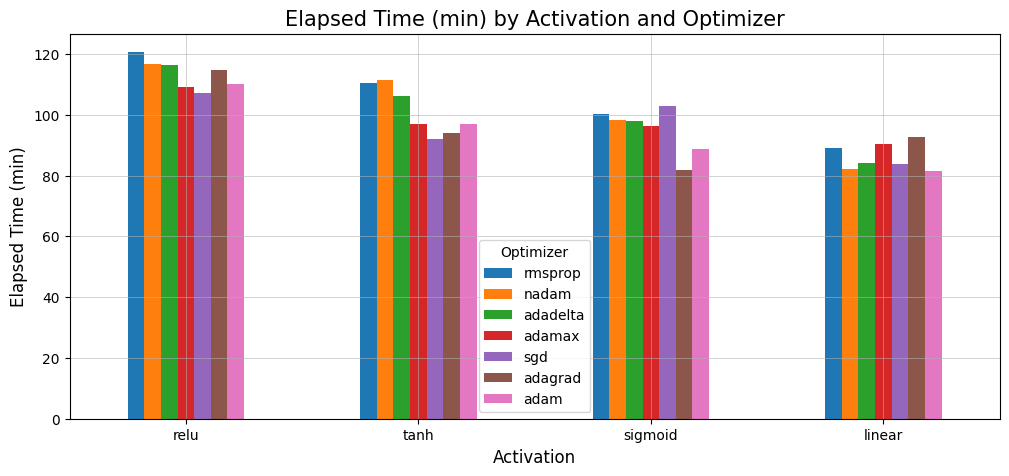

In [197]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_time = df_result.pivot_table(index='Activation', columns='Optimizer', values='Elapsed Time (min)')
# Sort the columns based on the mean elapsed time value
df_time = df_time[df_time.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_time = df_time.sort_index(ascending=False)
# Sort the values in the x-axis in descending order based on the highest mean elapsed time value
df_time = df_time.sort_values(by=df_time.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_time.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Elapsed Time (min)', fontsize=12)
ax.set_title('Elapsed Time (min) by Activation and Optimizer', fontsize=15)
# formatter = ticker.PercentFormatter(xmax=1, decimals=0)
# ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.show()

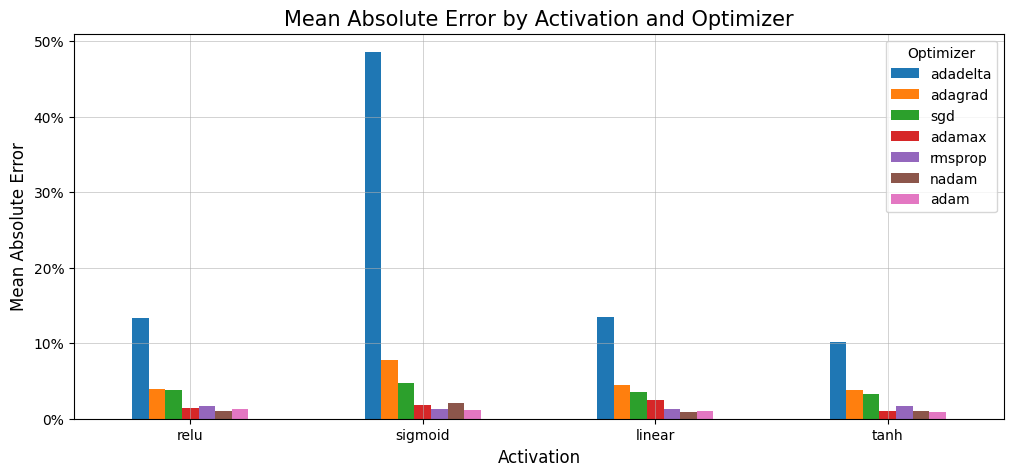

In [198]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_mae = df_result.pivot_table(index='Activation', columns='Optimizer', values='MAE (%)')
# Sort the columns based on the mean MAE value
df_mae = df_mae[df_mae.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_mae = df_mae.sort_index(ascending=False)
# Sort the values in the x-axis in descending order based on the highest mean MAE value
df_mae = df_mae.sort_values(by=df_mae.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_mae.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Mean Absolute Error', fontsize=12)
ax.set_title('Mean Absolute Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

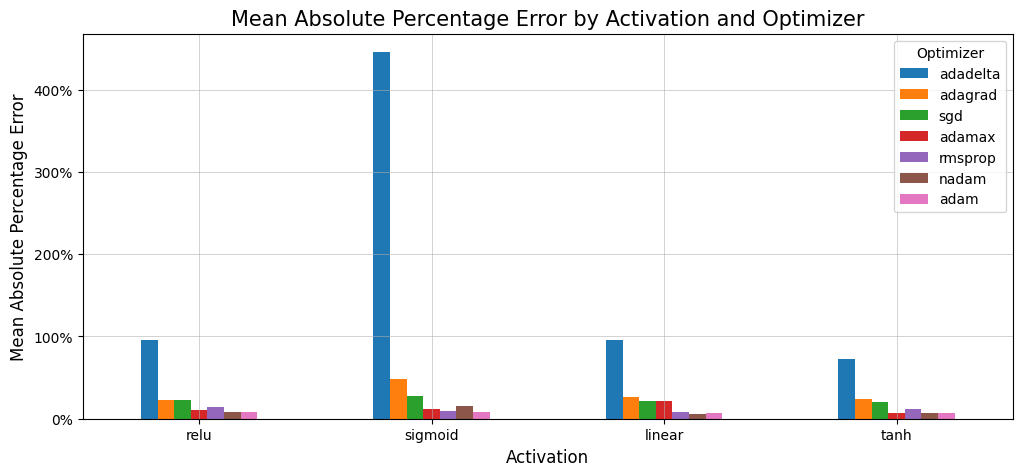

In [199]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_mape = df_result.pivot_table(index='Activation', columns='Optimizer', values='MAPE (%)')
# Sort the columns based on the mean MAPE value
df_mape = df_mape[df_mae.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_mape = df_mape.sort_index(ascending=False)
# Sort the values in the x-axis in descending order based on the highest mean MAPE value
df_mape = df_mape.sort_values(by=df_mape.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_mape.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Mean Absolute Percentage Error', fontsize=12)
ax.set_title('Mean Absolute Percentage Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

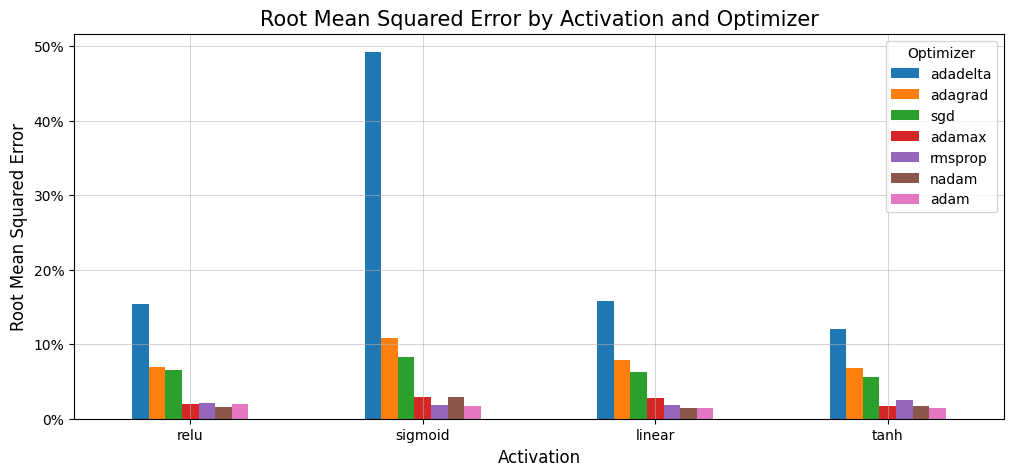

In [200]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_rmse = df_result.pivot_table(index='Activation', columns='Optimizer', values='RMSE (%)')
# Sort the columns based on the mean RMSE value
df_rmse = df_rmse[df_rmse.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_rmse = df_rmse.sort_index(ascending=False)
# Sort the values in the x-axis in descending order based on the highest mean RMSE value
df_rmse = df_rmse.sort_values(by=df_rmse.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_rmse.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Root Mean Squared Error', fontsize=12)
ax.set_title('Root Mean Squared Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

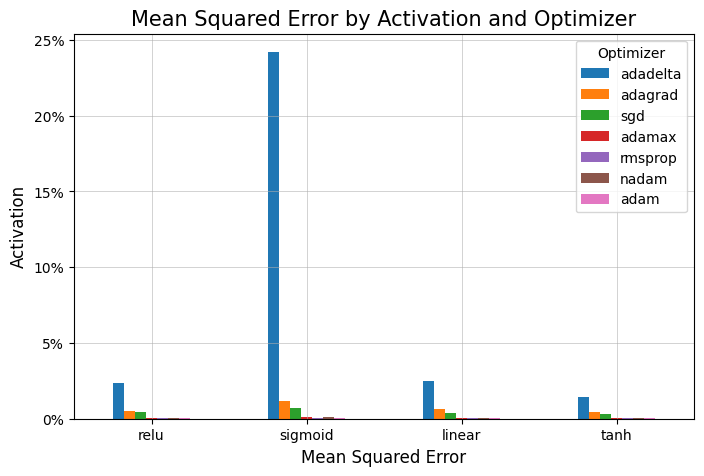

In [201]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_mse = df_result.pivot_table(index='Activation', columns='Optimizer', values='MSE (%)')
# Sort the columns based on the mean MSE value
df_mse = df_mse[df_mse.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_mse = df_mse.sort_index(ascending=False)
# Sort the values in the x-axis in descending order based on the highest mean MSE value
df_mse = df_mse.sort_values(by=df_mse.columns[-1], ascending=False)

# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(8,5))
df_mse.plot(kind='bar', ax=ax) # modified line
ax.set_xlabel('Mean Squared Error', fontsize=12)
ax.set_ylabel('Activation', fontsize=12) # modified line
ax.set_title('Mean Squared Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

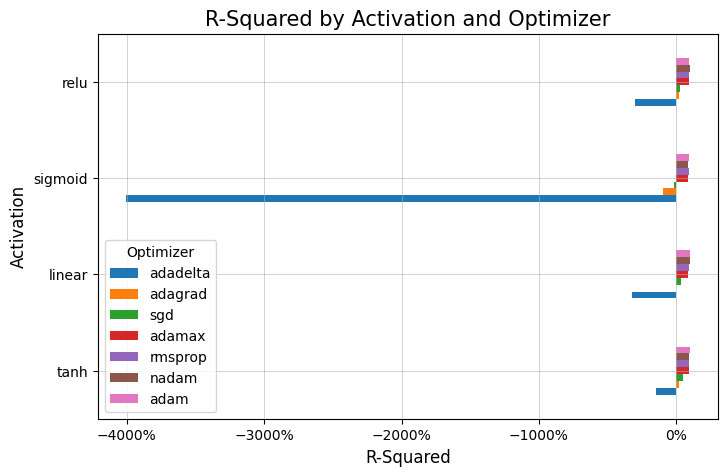

In [202]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_r2 = df_result.pivot_table(index='Activation', columns='Optimizer', values='R-Squared (%)')
# Sort the columns based on the mean R2 value
df_r2 = df_r2[df_r2.mean().sort_values(ascending=True).index]
# Sort the rows based on the activation function
df_r2 = df_r2.sort_index(ascending=True)
# Sort the values in the x-axis in descending order based on the highest mean R2 value
df_r2 = df_r2.sort_values(by=df_rmse.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(8,5))
df_r2.plot(kind='barh', ax=ax)
ax.set_xlabel('R-Squared', fontsize=12)
ax.set_ylabel('Activation', fontsize=12)
ax.set_title('R-Squared by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.xaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()